<center>
    
## Aprendizaje No Supervisado DiploDatos
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Agrupamiento con el FIFA 2021 dataset
 
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Clustering KM](#3.-Clustering-con-Kmeans)
4. [Clustering MS](#4.-Clustering-con-Mean-Shift)
5. [Clustering KM2](#5.-Clustering-con-Kmeans-sin-arqueros)
6. [Clustering MS2](#6.-Clustering-con-Mean-Shift-sin-arqueros)

## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io


In [2]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

from matplotlib import cm
from sklearn.decomposition import PCA

In [3]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import metrics

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [4]:
df=pd.read_csv("players_21.csv")

In [5]:
df.tail(4)

sofifa_id                                         player_url  \
18940     257710  https://sofifa.com/player/257710/mengxuan-zhan...   
18941     250989  https://sofifa.com/player/250989/zhenghao-wang...   
18942     257697  https://sofifa.com/player/257697/zitong-chen/2...   
18943     257936   https://sofifa.com/player/257936/yue-song/210002   

           short_name       long_name  age         dob  height_cm  weight_kg  \
18940  Zhang Mengxuan  Mengxuan Zhang   21  1999-04-26        177         70   
18941   Wang Zhenghao             王政豪   20  2000-06-28        185         74   
18942     Chen Zitong     Zitong Chen   23  1997-02-20        186         80   
18943        Song Yue        Yue Song   28  1991-11-20        185         79   

      nationality                            club_name           league_name  \
18940    China PR  Chongqing Dangdai Lifan FC SWM Team  Chinese Super League   
18941    China PR                      Tianjin TEDA FC  Chinese Super League   
18942    China PR        Shijiazhuang Ever Bright F.C.  Chinese Super League   
18943    China PR                      Tianjin TEDA FC  Chinese Super League   

       league_rank  overall  potential  value_eur  wage_eur player_positions  \
18940          1.0       47         52      35000      1000               CB   
18941          1.0       47         51      35000      1000               CB   
18942          1.0       47         51      40000      1000               CM   
18943          1.0       47         47      30000      2000               CM   

      preferred_foot  international_reputation  weak_foot  skill_moves  \
18940          Right                         1          2            2   
18941          Right                         1          2            2   
18942          Right                         1          2            2   
18943          Right                         1          2            2   

        work_rate body_type real_face  release_clause_eur player_tags  \
18940     Low/Low    Normal        No             57000.0         NaN   
18941  Low/Medium    Normal        No             57000.0         NaN   
18942     Low/Low      Lean        No             65000.0         NaN   
18943     Low/Low      Lean        No             47000.0         NaN   

      team_position  team_jersey_number loaned_from      joined  \
18940           SUB                25.0         NaN  2020-08-01   
18941           RES                 2.0         NaN  2019-02-01   
18942           RDM                 4.0         NaN  2020-08-01   
18943           RES                33.0         NaN  2020-08-01   

       contract_valid_until nation_position  nation_jersey_number  pace  \
18940                2020.0             NaN                   NaN  58.0   
18941                2022.0             NaN                   NaN  51.0   
18942                2023.0             NaN                   NaN  61.0   
18943                2022.0             NaN                   NaN  65.0   

       shooting  passing  dribbling  defending  physic  gk_diving  \
18940      23.0     26.0       27.0       50.0    48.0        NaN   
18941      25.0     29.0       36.0       45.0    55.0        NaN   
18942      35.0     48.0       48.0       44.0    58.0        NaN   
18943      37.0     49.0       46.0       40.0    59.0        NaN   

       gk_handling  gk_kicking  gk_reflexes  gk_speed  gk_positioning  \
18940          NaN         NaN          NaN       NaN             NaN   
18941          NaN         NaN          NaN       NaN             NaN   
18942          NaN         NaN          NaN       NaN             NaN   
18943          NaN         NaN          NaN       NaN             NaN   

      player_traits  attacking_crossing  attacking_finishing  \
18940           NaN                  23                   16   
18941           NaN                  20                   20   
18942           NaN                  38                   32   
18943           NaN            

**Preparamos la base para Clustering:**

**Retiramos jugadores con bajo Desempeño global ("Overall") y consideramos Variables de desempeño por habilidad (skills_ratings)**

In [6]:
n=10000
df_n=df.loc[:n] #los primeros n
df_n=df_n[(df_n['overall']>70)] # mejores jugadores

skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
                  'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
                  'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions',
                  'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
                  'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 
                  'mentality_composure', 'defending_standing_tackle', 'defending_sliding_tackle',
                  'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
print(len(skills_ratings), 'variables numéricas: skills/habilidades')

df_skills=df_n[skills_ratings]

33 variables numéricas: skills/habilidades


In [7]:
df_skills.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4512 entries, 0 to 4511
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   attacking_crossing          4512 non-null   int64
 1   attacking_finishing         4512 non-null   int64
 2   attacking_heading_accuracy  4512 non-null   int64
 3   attacking_short_passing     4512 non-null   int64
 4   attacking_volleys           4512 non-null   int64
 5   skill_dribbling             4512 non-null   int64
 6   skill_curve                 4512 non-null   int64
 7   skill_fk_accuracy           4512 non-null   int64
 8   skill_long_passing          4512 non-null   int64
 9   skill_ball_control          4512 non-null   int64
 10  movement_acceleration       4512 non-null   int64
 11  movement_sprint_speed       4512 non-null   int64
 12  movement_agility            4512 non-null   int64
 13  movement_reactions          4512 non-null   int64
 14  movement

Se elimina el skill 'defending_marking', porque tiene todos los valores en nulos (NaN).

In [8]:
#df_skills=df_skills.drop(['defending_marking'], axis=1)

In [9]:
df_skills.tail(4)

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
4508                  68                   68                          48   
4509                  67                   55                          51   
4510                  14                    6                          13   
4511                  59                   70                          50   

      attacking_short_passing  attacking_volleys  skill_dribbling  \
4508                       69                 61               73   
4509                       73                 51               73   
4510                       21                  9                9   
4511                       75                 61               73   

      skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
4508           53                 42                  57                  71   
4509           81                 63                  71                  75   
4510           14                 11                  21                  18   
4511           59                 59                  73                  74   

      movement_acceleration  movement_sprint_speed  movement_agility  \
4508                     83                     82                81   
4509                     79                     73                80   
4510                     28                     16                21   
4511                     66                     67                74   

      movement_reactions  movement_balance  power_shot_power  power_jumping  \
4508                  64                78                78             56   
4509                  71                83                75             69   
4510                  69                26                53             33   
4511                  72                69                71             76   

      power_stamina  power_strength  power_long_shots  mentality_aggression  \
4508             69              63                58                    33   
4509             88              81                61                    83   
4510             24              60                 6                    28   
4511             85              73                65                    69   

      mentality_interceptions  mentality_positioning  mentality_vision  \
4508                       27                     69                66   
4509                       63                     59                71   
4510                        7                      8                51   
4511                       64                     59                74   

      mentality_penalties  mentality_composure  defending_standing_tackle  \
4508                   66                   67                         35   
4509                   61                   81                         69   
4510                   19                   29                         14   
4511                   57                   80                         63   

      defending_sliding_tackle  goalkeeping_diving  goalkeeping_handling  \
4508                        34                   8                     8   
4509                        59                  12                     9   
4510                        11                  71                    72   
4511                        66                  13                    13   

      goalkeeping_kicking  goalkeeping_positioning  goalkeeping_reflexes  
4508                   10                       14                    10  
4509                   10                       13                     9  
4510                   71                       71                    67  
4511                    9                       13                    16

# 3.-Clustering-con-Kmeans

ES necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo. 


In [10]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust,random_state=42)
km.fit(df_skills) #utiliza todas las habilidades: 34 dimensiones

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=inertia=  11098847.52898096


**Elección de la cantidad de grupos/clusters**

Una forma de seleccionar la cantidad más adecuada de clusters es probar varias cantidades y usar el criterio del codo: "elbow method", utilizando una medida de ajuste que puede ser Inertia.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

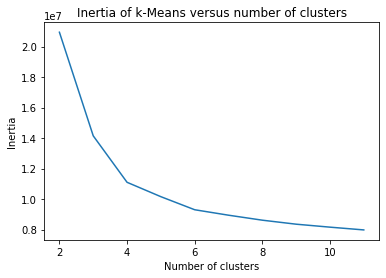

In [11]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 cl1sters
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

**Graficamos el resultado de agrupar a los jugadores usando kmedias con la cantidad de clases elegida: Visualizamos las variables attacking_finishing y defending_sliding_tackle**

In [12]:
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

In [13]:
kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [14]:
#En Colab:
#fig.show(renderer="colab")

In [15]:
#En Jupyter:
iplot(fig)

In [16]:
df_clusters=df_n.copy()
labels = km.labels_
df_clusters['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')


Kmeans encontró:  4 clusters, nosotros forzamos la cantidad


**EVALUACIÓN**

**EJERCICIO: Análisis exploratorio de los clusters, usando las clases asignadas por kmeans** 
- Cantidad de observaciones por Cluster
- Análisis descriptivo separando por Cluster
- Tabla de contingencia alguna categórica vs clusters
- Silohuette?


**Cantidad de observaciones por Cluster**

In [17]:
df_clusters.kmeans.value_counts()

3    1682
2    1465
0     921
1     444
Name: kmeans, dtype: int64

Se advierte que el Cluster con mayor cantidad de casos es el 3, contando con 1682 jugadores, seguido por el 2 con 1465 jugadores. Luego, el Cluster 0 agrupa 921 jugadores y el 1 es el más pequeño, con 444 jugadores

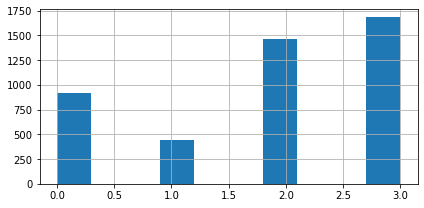

In [18]:
df_clusters.kmeans.hist(figsize=(6, 3))
plt.tight_layout()

**Análisis descriptivo separando por Cluster**

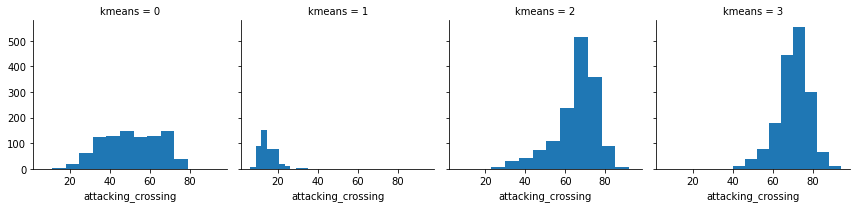

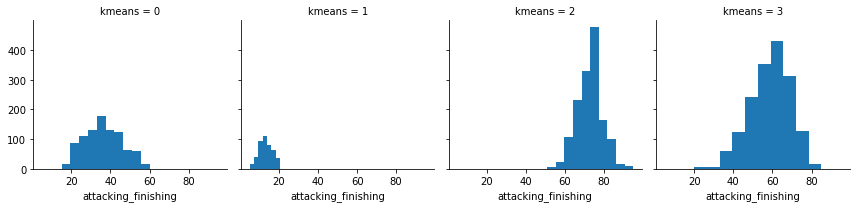

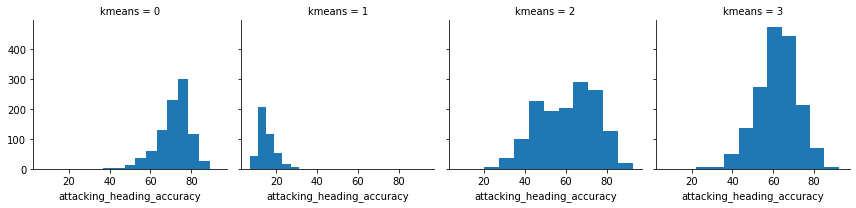

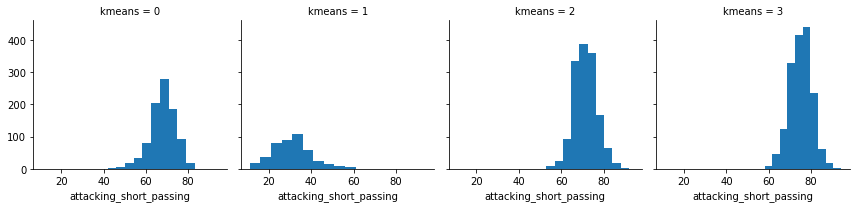

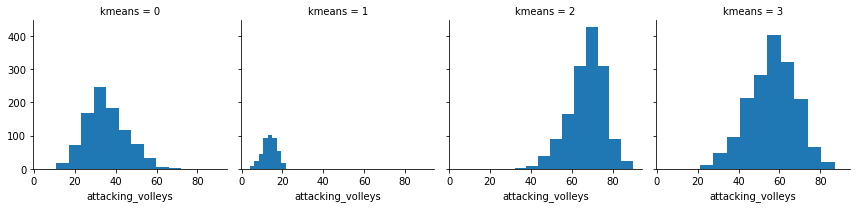

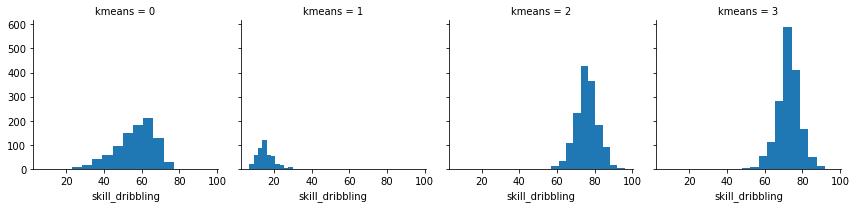

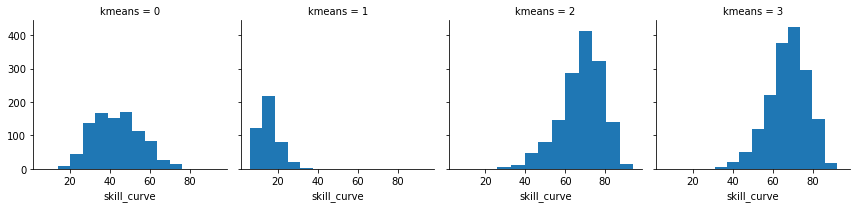

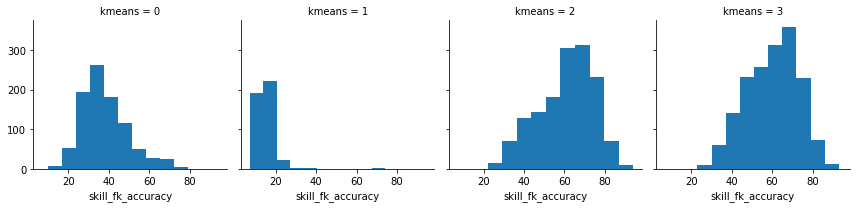

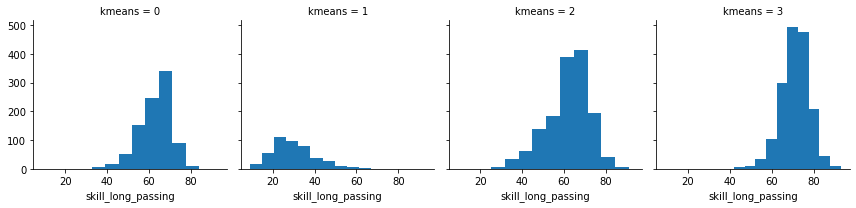

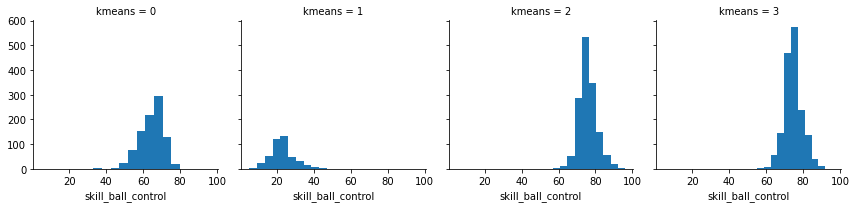

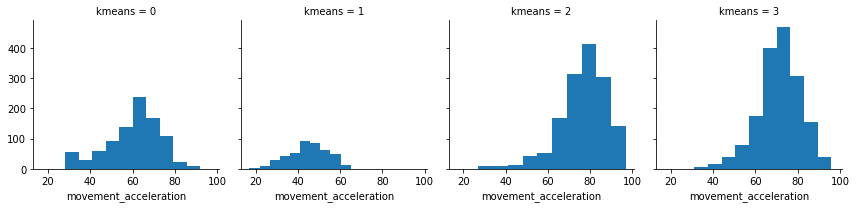

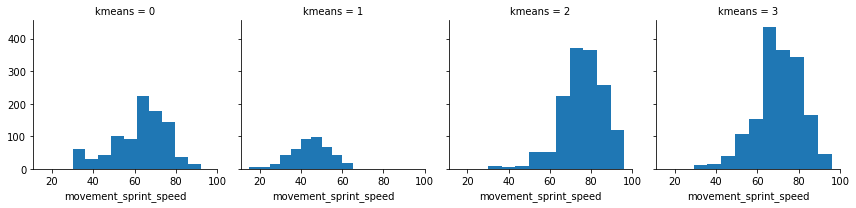

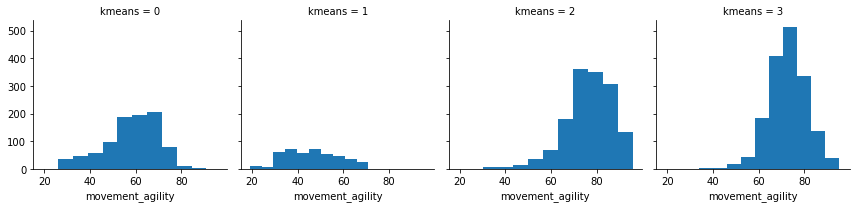

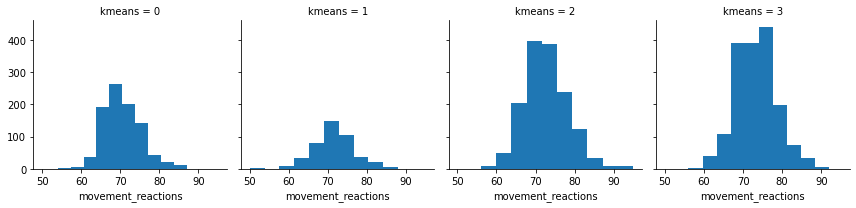

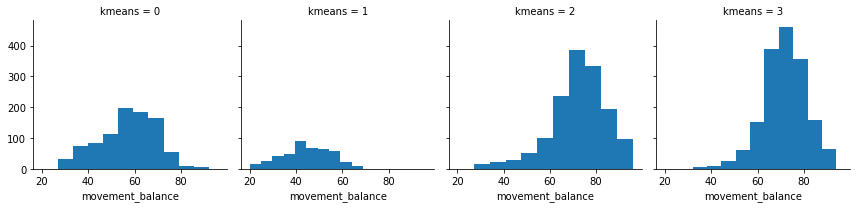

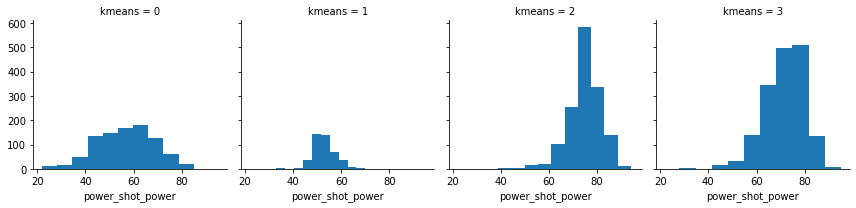

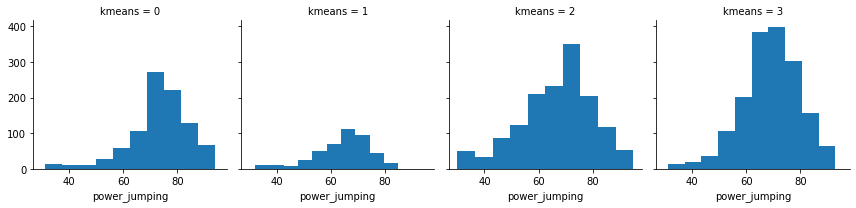

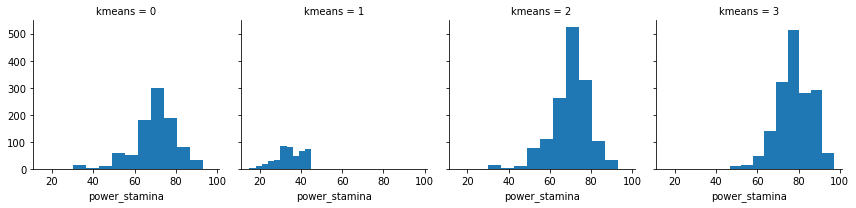

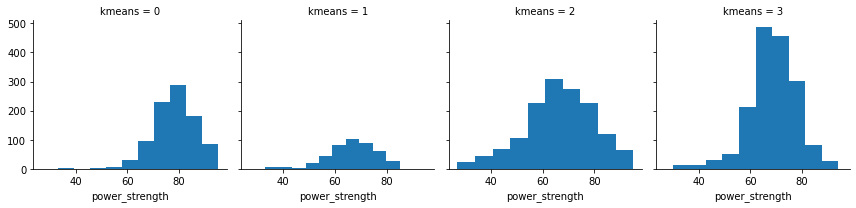

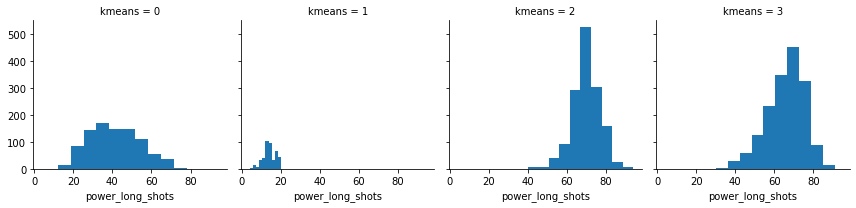

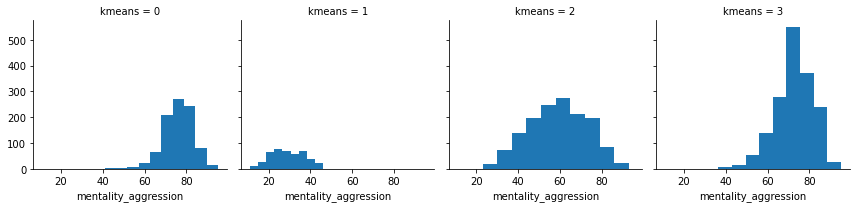

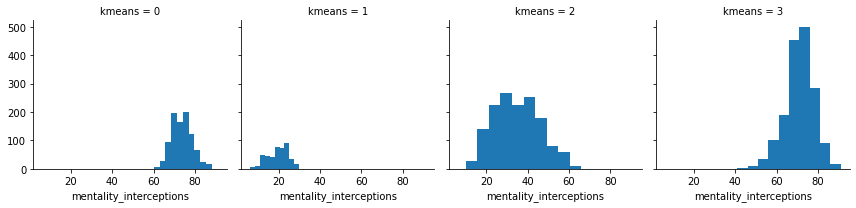

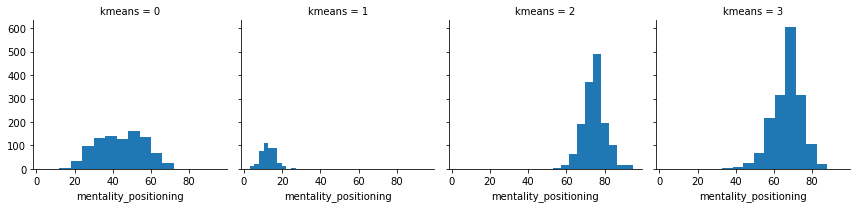

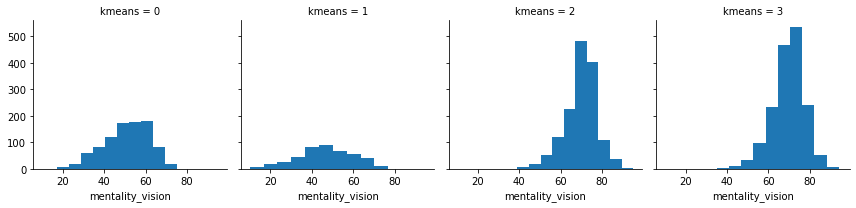

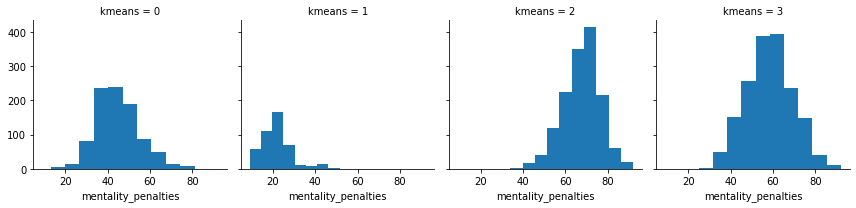

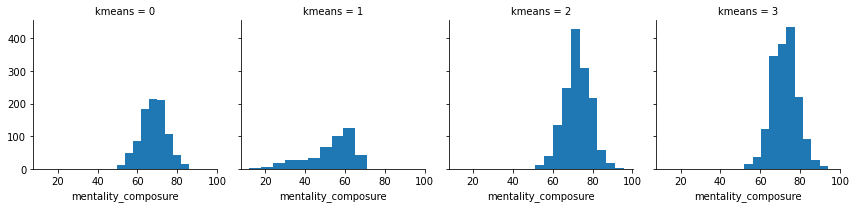

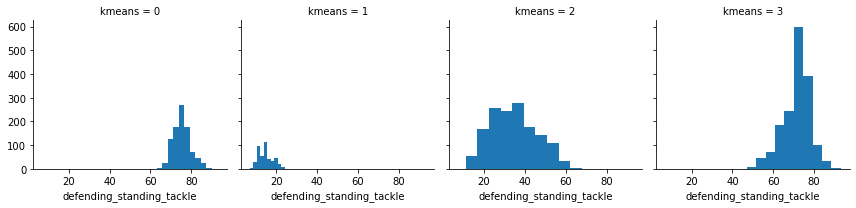

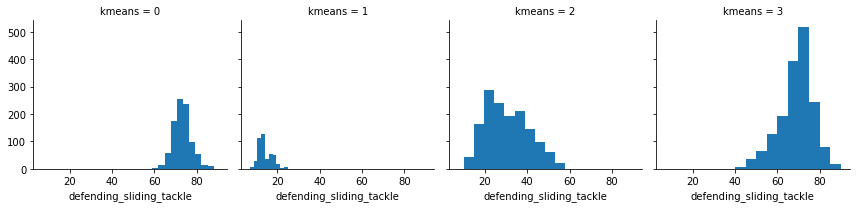

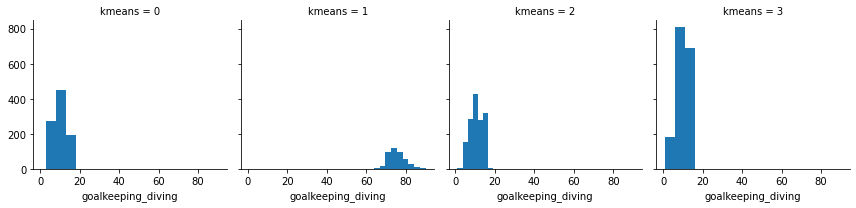

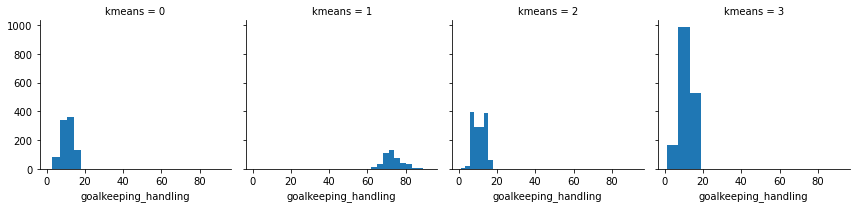

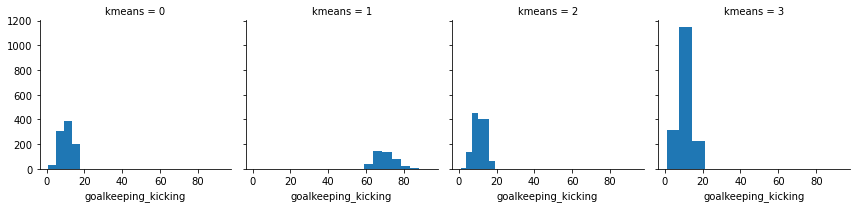

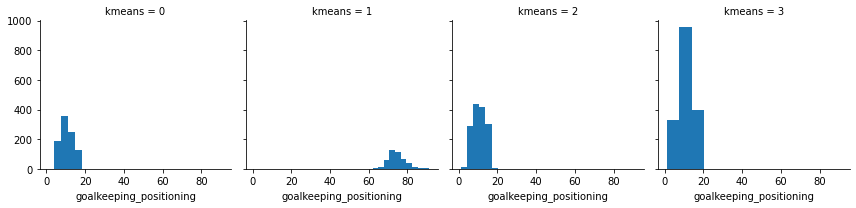

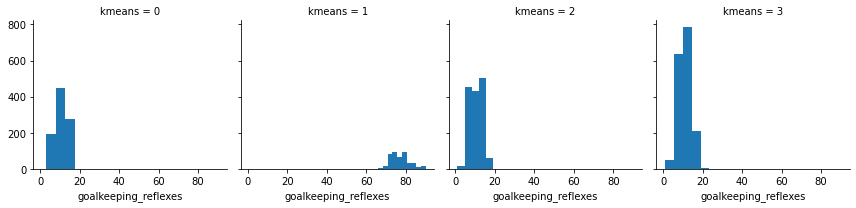

In [19]:
for c in df_clusters[skills_ratings]:
    grid = sns.FacetGrid(df_clusters, col='kmeans')
    grid.map(plt.hist, c)

In [20]:
df_clusters_0=df_clusters[df_clusters["kmeans"]==0]
df_clusters_0.describe()

sofifa_id         age   height_cm   weight_kg  league_rank  \
count     921.000000  921.000000  921.000000  921.000000   902.000000   
mean   212304.032573   27.363735  185.371336   79.762215     1.118625   
std     24577.584575    4.036134    5.618003    6.197907     0.326939   
min     20209.000000   18.000000  165.000000   60.000000     1.000000   
25%    198230.000000   24.000000  182.000000   75.000000     1.000000   
50%    214639.000000   27.000000  186.000000   80.000000     1.000000   
75%    230390.000000   30.000000  189.000000   84.000000     1.000000   
max    258370.000000   42.000000  199.000000  101.000000     3.000000   

          overall   potential     value_eur       wage_eur  \
count  921.000000  921.000000  9.210000e+02     921.000000   
mean    73.948969   76.555917  5.648344e+06   21819.218241   
std      3.012763    4.298555  5.831588e+06   22985.856943   
min     71.000000   71.000000  0.000000e+00       0.000000   
25%     72.000000   73.000000  2.600000e+06    8000.000000   
50%     73.000000   76.000000  3.900000e+06   16000.000000   
75%     75.000000   79.000000  7.000000e+06   27000.000000   
max     88.000000   92.000000  5.600000e+07  220000.000000   

       international_reputation   weak_foot  skill_moves  release_clause_eur  \
count                921.000000  921.000000   921.000000        8.700000e+02   
mean                   1.257329    2.855592     2.170467        1.114785e+07   
std                    0.543752    0.598725     0.376247        1.158149e+07   
min                    1.000000    1.000000     2.000000        7.130000e+05   
25%                    1.000000    3.000000     2.000000        4.925000e+06   
50%                    1.000000    3.000000     2.000000        7.600000e+06   
75%                    1.000000    3.000000     2.000000        1.347500e+07   
max                    4.000000    5.000000     3.000000        1.078000e+08   

       team_jersey_number  contract_valid_until  nation_jersey_number  \
count          902.000000            902.000000            133.000000   
mean            15.883592           2022.195122              9.338346   
std             14.768159              1.158695              6.621690   
min              2.000000           2020.000000              2.000000   
25%              4.000000           2021.000000              4.000000   
50%             14.000000           2022.000000              6.000000   
75%             23.000000           2023.000000             15.000000   
max             97.000000           2027.000000             23.000000   

             pace    shooting     passing   dribbling   defending      physic  \
count  921.000000  921.000000  921.000000  921.000000  921.000000  921.000000   
mean    61.604777   42.044517   57.517915   59.793702   73.932682   75.352877   
std     12.565833    8.171609    6.573659    7.607834    4.183278    5.032537   
min     30.000000   18.000000   35.000000   34.000000   64.000000   49.000000   
25%     54.000000   36.000000   53.000000   54.000000   71.000000   73.000000   
50%     64.000000   42.000000   58.000000   61.000000   74.000000   76.000000   
75%     70.000000   48.000000   63.000000   66.000000   76.000000   79.000000   
max     91.000000   62.000000   73.000000   76.000000   90.000000   91.000000   

       gk_diving  gk_handling  gk_kicking  gk_reflexes  gk_speed  \
count        0.0          0.0         0.0          0.0       0.0   
mean         NaN          NaN         NaN          NaN       NaN   
std          NaN          NaN         NaN          NaN       NaN   
min          NaN          NaN         NaN          NaN       NaN   
25%          NaN          NaN         NaN          NaN       NaN   
50%          NaN          NaN         NaN          NaN       NaN   
75%          NaN          NaN         NaN          NaN       NaN   
max          NaN          NaN         NaN          NaN       NaN   

       gk_positioning  attacking_crossing  attacking_finishing  \
count 

In [21]:
df_clusters_1=df_clusters[df_clusters["kmeans"]==1]
df_clusters_1.describe()

sofifa_id         age   height_cm   weight_kg  league_rank  \
count     444.000000  444.000000  444.000000  444.000000   433.000000   
mean   197309.355856   29.772523  189.157658   83.795045     1.117783   
std     35290.571053    4.386524    4.520573    6.020722     0.329819   
min      1179.000000   20.000000  175.000000   64.000000     1.000000   
25%    183435.000000   27.000000  186.000000   80.000000     1.000000   
50%    201628.000000   30.000000  189.000000   83.000000     1.000000   
75%    221590.500000   33.000000  192.000000   88.000000     1.000000   
max    253343.000000   42.000000  203.000000  103.000000     3.000000   

          overall   potential     value_eur       wage_eur  \
count  444.000000  444.000000  4.440000e+02     444.000000   
mean    75.360360   76.975225  6.369595e+06   21164.414414   
std      4.078336    4.755115  8.744030e+06   29145.912124   
min     71.000000   71.000000  0.000000e+00       0.000000   
25%     72.000000   73.000000  1.900000e+06    6000.000000   
50%     74.000000   76.000000  3.600000e+06   13000.000000   
75%     77.000000   80.000000  7.000000e+06   26000.000000   
max     91.000000   93.000000  7.500000e+07  260000.000000   

       international_reputation   weak_foot  skill_moves  release_clause_eur  \
count                444.000000  444.000000        444.0        4.210000e+02   
mean                   1.342342    2.666667          1.0        1.245767e+07   
std                    0.658276    0.724712          0.0        1.767175e+07   
min                    1.000000    1.000000          1.0        3.240000e+05   
25%                    1.000000    2.000000          1.0        3.500000e+06   
50%                    1.000000    3.000000          1.0        6.800000e+06   
75%                    2.000000    3.000000          1.0        1.370000e+07   
max                    5.000000    5.000000          1.0        1.594000e+08   

       team_jersey_number  contract_valid_until  nation_jersey_number  pace  \
count          433.000000            433.000000             99.000000   0.0   
mean            16.013857           2022.129330             10.525253   NaN   
std             20.198891              1.189029              8.624057   NaN   
min              1.000000           2020.000000              1.000000   NaN   
25%              1.000000           2021.000000              1.000000   NaN   
50%             12.000000           2022.000000             12.000000   NaN   
75%             26.000000           2023.000000             17.000000   NaN   
max             99.000000           2025.000000             23.000000   NaN   

       shooting  passing  dribbling  defending  physic   gk_diving  \
count       0.0      0.0        0.0        0.0     0.0  444.000000   
mean        NaN      NaN        NaN        NaN     NaN   75.594595   
std         NaN      NaN        NaN        NaN     NaN    4.497561   
min         NaN      NaN        NaN        NaN     NaN   61.000000   
25%         NaN      NaN        NaN        NaN     NaN   72.000000   
50%         NaN      NaN        NaN        NaN     NaN   75.000000   
75%         NaN      NaN        NaN        NaN     NaN   78.000000   
max         NaN      NaN        NaN        NaN     NaN   90.000000   

       gk_handling  gk_kicking  gk_reflexes    gk_speed  gk_positioning  \
count   444.000000  444.000000   444.000000  444.000000      444.000000   
mean     72.664414   70.373874    77.060811   44.448198       74.567568   
std       4.683432    6.085163     4.657904    8.844507        4.538517   
min      62.000000   44.000000    66.000000   18.000000       62.000000   
25%      69.000000   66.000000    74.000000   39.000000       72.000000   
50%      72.000000   70.000000    76.000000   45.000000       74.000000   
75%      76.000000   74.000000    80.000000   50.000000       77.000000   
max      92.000000   93.000000    90.000000   65.000000       91.000000   

       attacking_crossing  attacking_finishing  attack

In [22]:
df_clusters_3=df_clusters[df_clusters["kmeans"]==2]
df_clusters_3.describe()

sofifa_id         age    height_cm    weight_kg  league_rank  \
count    1465.000000  1465.00000  1465.000000  1465.000000  1438.000000   
mean   211502.774061    27.08942   179.020478    74.208191     1.088317   
std     27315.567568     4.10395     6.795077     7.209468     0.283854   
min      3467.000000    17.00000   157.000000    55.000000     1.000000   
25%    198429.000000    24.00000   174.000000    69.000000     1.000000   
50%    214434.000000    27.00000   179.000000    74.000000     1.000000   
75%    230475.000000    30.00000   184.000000    79.000000     1.000000   
max    258262.000000    39.00000   201.000000   104.000000     2.000000   

           overall    potential     value_eur       wage_eur  \
count  1465.000000  1465.000000  1.465000e+03    1465.000000   
mean     74.931741    77.223208  8.511945e+06   28684.641638   
std       3.712626     4.838372  9.998090e+06   39074.573200   
min      71.000000    71.000000  0.000000e+00       0.000000   
25%      72.000000    73.000000  3.300000e+06   10000.000000   
50%      74.000000    76.000000  5.500000e+06   18000.000000   
75%      77.000000    80.000000  9.500000e+06   34000.000000   
max      93.000000    95.000000  1.055000e+08  560000.000000   

       international_reputation    weak_foot  skill_moves  release_clause_eur  \
count               1465.000000  1465.000000  1465.000000        1.376000e+03   
mean                   1.397952     3.384300     3.392491        1.664208e+07   
std                    0.710477     0.716053     0.612549        1.961454e+07   
min                    1.000000     1.000000     2.000000        1.100000e+06   
25%                    1.000000     3.000000     3.000000        6.100000e+06   
50%                    1.000000     3.000000     3.000000        1.070000e+07   
75%                    2.000000     4.000000     4.000000        1.900000e+07   
max                    5.000000     5.000000     5.000000        2.031000e+08   

       team_jersey_number  contract_valid_until  nation_jersey_number  \
count         1438.000000           1438.000000            240.000000   
mean            18.457580           2022.311544             14.220833   
std             15.889426              1.287061              5.235578   
min              2.000000           2020.000000              3.000000   
25%              9.000000           2021.000000             10.000000   
50%             13.000000           2022.000000             14.000000   
75%             22.000000           2023.000000             19.000000   
max             99.000000           2028.000000             27.000000   

              pace     shooting      passing    dribbling    defending  \
count  1465.000000  1465.000000  1465.000000  1465.000000  1465.000000   
mean     76.008191    72.131741    67.823208    75.606143    37.592491   
std      10.362814     5.460587     7.204526     5.337883     7.989650   
min      30.000000    54.000000    44.000000    58.000000    18.000000   
25%      70.000000    69.000000    64.000000    72.000000    32.000000   
50%      77.000000    72.000000    68.000000    75.000000    37.000000   
75%      83.000000    75.000000    72.000000    79.000000    43.000000   
max      96.000000    93.000000    91.000000    95.000000    61.000000   

            physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  gk_speed  \
count  1465.000000        0.0          0.0         0.0          0.0       0.0   
mean     65.645734        NaN          NaN         NaN          NaN       NaN   
std       9.078180        NaN          NaN         NaN          NaN       NaN   
min      37.000000        NaN          NaN         NaN          NaN       NaN   
25%      60.000000        NaN          NaN         NaN          NaN       NaN   
50%      66.000000        NaN          NaN         NaN          NaN       NaN   
75%      72.000000        NaN          NaN         NaN          NaN       NaN   
max      90.000000        NaN          NaN         NaN 

In [23]:
df_clusters_3=df_clusters[df_clusters["kmeans"]==3]
df_clusters_3.describe()

sofifa_id          age    height_cm    weight_kg  league_rank  \
count    1682.000000  1682.000000  1682.000000  1682.000000  1650.000000   
mean   210344.030321    27.387039   179.232461    73.909037     1.096364   
std     24075.663614     3.875136     5.683613     5.935259     0.303285   
min        41.000000    17.000000   164.000000    56.000000     1.000000   
25%    194782.250000    24.000000   175.000000    70.000000     1.000000   
50%    211480.000000    27.000000   179.000000    74.000000     1.000000   
75%    230019.750000    30.000000   183.000000    78.000000     1.000000   
max    257533.000000    38.000000   197.000000    96.000000     3.000000   

           overall    potential     value_eur       wage_eur  \
count  1682.000000  1682.000000  1.682000e+03    1682.000000   
mean     75.165279    77.344233  7.798796e+06   29296.967895   
std       3.600189     4.485663  8.124070e+06   34869.263046   
min      71.000000    71.000000  0.000000e+00       0.000000   
25%      72.000000    74.000000  3.100000e+06   10000.000000   
50%      74.000000    77.000000  5.500000e+06   19000.000000   
75%      77.000000    80.000000  9.000000e+06   36000.000000   
max      91.000000    92.000000  8.700000e+07  370000.000000   

       international_reputation    weak_foot  skill_moves  release_clause_eur  \
count               1682.000000  1682.000000  1682.000000        1.592000e+03   
mean                   1.368014     3.168847     3.017241        1.530484e+07   
std                    0.645858     0.689881     0.552158        1.612342e+07   
min                    1.000000     1.000000     2.000000        6.160000e+05   
25%                    1.000000     3.000000     3.000000        6.000000e+06   
50%                    1.000000     3.000000     3.000000        1.050000e+07   
75%                    2.000000     4.000000     3.000000        1.780000e+07   
max                    4.000000     5.000000     5.000000        1.610000e+08   

       team_jersey_number  contract_valid_until  nation_jersey_number  \
count         1650.000000           1650.000000            318.000000   
mean            18.323030           2022.314545             11.547170   
std             15.335283              1.204336              6.477525   
min              2.000000           2020.000000              2.000000   
25%              8.000000           2021.000000              6.000000   
50%             16.000000           2022.000000             11.000000   
75%             24.000000           2023.000000             17.000000   
max             98.000000           2026.000000             26.000000   

              pace     shooting      passing    dribbling    defending  \
count  1682.000000  1682.000000  1682.000000  1682.000000  1682.000000   
mean     70.719382    62.878716    71.149822    73.206302    69.131986   
std      10.106734     7.873375     5.071543     4.840552     6.618916   
min      30.000000    39.000000    57.000000    55.000000    46.000000   
25%      65.000000    58.000000    68.000000    70.000000    66.000000   
50%      71.000000    64.000000    71.000000    73.000000    70.000000   
75%      77.000000    68.000000    74.000000    76.000000    73.000000   
max      96.000000    86.000000    93.000000    90.000000    91.000000   

            physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  gk_speed  \
count  1682.000000        0.0          0.0         0.0          0.0       0.0   
mean     71.674197        NaN          NaN         NaN          NaN       NaN   
std       6.577387        NaN          NaN         NaN          NaN       NaN   
min      45.000000        NaN          NaN         NaN          NaN       NaN   
25%      68.000000        NaN          NaN         NaN          NaN       NaN   
50%      72.000000        NaN          NaN         NaN          NaN       NaN   
75%      76.000000        NaN          NaN         NaN          NaN       NaN   
max      91.000000        NaN          NaN    

A partir del análisis descriptivo de los clusters pudimos detectar algunas diferencias entre ellos. Por ejemplo, los jugadores pertenecientes a los clusters 0 y 1 poseen en promedio mayor altura y peso que los pertenecientes a los clusters 2 y 3. Una tendencia similar entre grupos se observó con respecto al sueldo de los jugadores, siendo en promedio mayor para los que se encuentran incluidos en los grupos 2 y 3 con respecto a los clusters 1 y 0.

In [24]:
df_clusters.groupby(['kmeans'])[skills_ratings].mean()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
kmeans                                                                        
0                50.660152            36.065147                   71.675353   
1                14.966216            13.092342                   14.921171   
2                65.591809            72.713993                   60.918089   
3                69.662901            58.448276                   61.437574   

        attacking_short_passing  attacking_volleys  skill_dribbling  \
kmeans                                                                
0                     67.827362          35.617807        56.519001   
1                     30.677928          13.605856        15.450450   
2                     71.536519          67.350171        75.868259   
3                     74.988109          56.335315        72.626635   

        skill_curve  skill_fk_accuracy  skill_long_passing  \
kmeans                                                       
0         43.198697          37.680782           63.028230   
1         15.707207          15.029279           29.815315   
2         67.954266          60.627986           61.805461   
3         67.384067          59.526159           71.124851   

        skill_ball_control  movement_acceleration  movement_sprint_speed  \
kmeans                                                                     
0                64.472313              60.286645              62.647123   
1                22.837838              44.590090              44.344595   
2                75.813652              76.354949              75.729010   
3                74.715815              71.057669              70.424495   

        movement_agility  movement_reactions  movement_balance  \
kmeans                                                           
0              57.871878           70.492942         56.891422   
1              46.182432           71.405405         44.860360   
2              76.404096           72.559727         72.537201   
3              72.372771           73.031510         71.549346   

        power_shot_power  power_jumping  power_stamina  power_strength  \
kmeans                                                                   
0              56.795874      73.188925      69.807818       78.011944   
1              52.918919      64.576577      34.227477       66.247748   
2              74.731058      66.489420      69.992491       66.225939   
3              71.558264      68.993460      77.993460       68.422711   

        power_long_shots  mentality_aggression  mentality_interceptions  \
kmeans                                                                    
0              41.223670             75.978284                73.568947   
1              13.896396             29.076577                19.527027   
2              69.847782             58.466894                34.662116   
3              65.766944             72.501189                70.620095   

        mentality_positioning  mentality_vision  mentality_penalties  \
kmeans                                                                 
0                   43.780673         50.559175            44.485342   
1                   12.698198         46.765766            21.819820   
2                   74.450512         69.651877            67.483959   
3                   66.832342         69.666468            58.325803   

        mentality_composure  defending_standing_tackle  \
kmeans                                                   
0                 67.789359                  75.323561   
1                 53.195946                  14.677928   
2                 72.000000                  34.566553   
3                 72.130797                  71.236029   

        defending_sliding_tackle  goalkeeping_diving  goalkeeping_handling  \
kmeans                                                                       
0                      73.221498           10

**Observaciones**

Cluster 0: Agrupa a los defensores.

Cluster 1: Representa a los arqueros (gk).

Cluster 2: Agrupa a los jugadores delanteros.

Cluster 3: Agrupa a los jugadores de medio campo. 


**Tabla de contingencia alguna categórica vs clusters**

In [25]:
df_clusters.groupby(['preferred_foot','kmeans'])['kmeans'].count()

preferred_foot  kmeans
Left            0          219
                1           55
                2          372
                3          508
Right           0          702
                1          389
                2         1093
                3         1174
Name: kmeans, dtype: int64

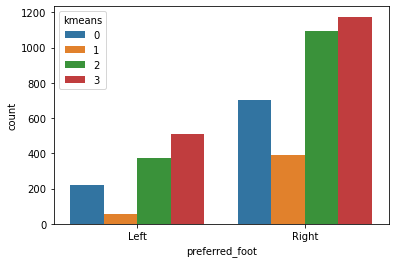

In [26]:
ax = sns.countplot(x="preferred_foot", hue="kmeans", data=df_clusters)

<AxesSubplot:xlabel='kmeans', ylabel='Percent'>

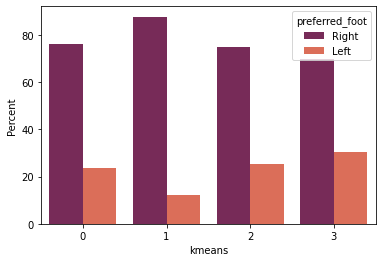

In [27]:
df_aux = df_clusters.groupby(['kmeans'])['preferred_foot'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
sns.barplot(x='kmeans', y='Percent', hue='preferred_foot', data=df_aux, palette='rocket')

Podemos observar que la mayoria de los jugadores son derechos. Y en el cluster 3 y 2 hay mas zurdos que en el claste 0 y 1.

**Silhouette Coefficient Method**

For n_clusters = 2 The average silhouette_score is : 0.6413157990914239
For n_clusters = 3 The average silhouette_score is : 0.33693767836491945
For n_clusters = 4 The average silhouette_score is : 0.30988045957867183
For n_clusters = 5 The average silhouette_score is : 0.277313644449022
For n_clusters = 6 The average silhouette_score is : 0.2381995945203806
For n_clusters = 7 The average silhouette_score is : 0.22442350335660588
For n_clusters = 8 The average silhouette_score is : 0.2109595584589149
For n_clusters = 9 The average silhouette_score is : 0.19324399753666507
For n_clusters = 10 The average silhouette_score is : 0.18734247501401977
For n_clusters = 11 The average silhouette_score is : 0.1777028062697917


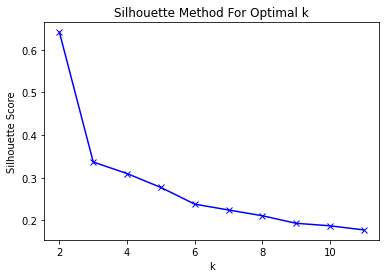

In [28]:
silhouette_scores = [] 
K = range(2, 12)

for k in K:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(df_skills)
    scr = silhouette_score(df_skills, km)
    silhouette_scores.append(scr)
    print("For n_clusters =", k, "The average silhouette_score is :", scr)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

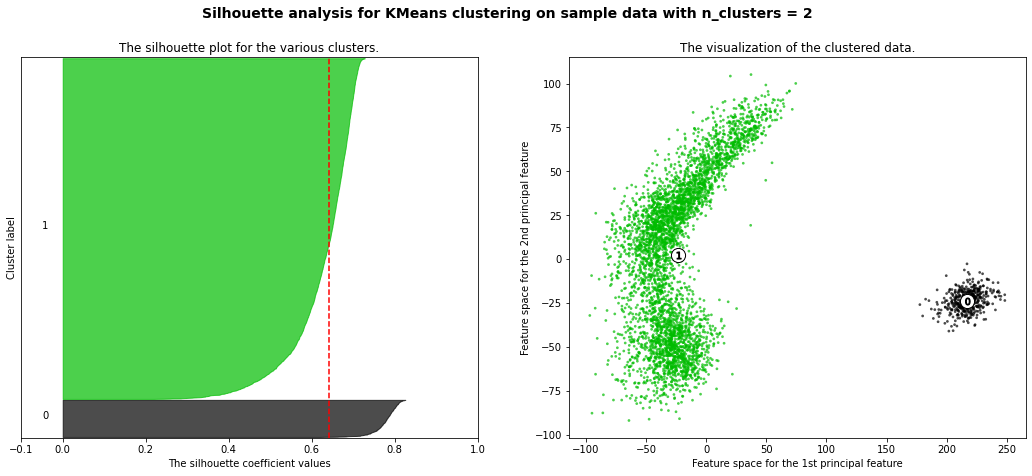

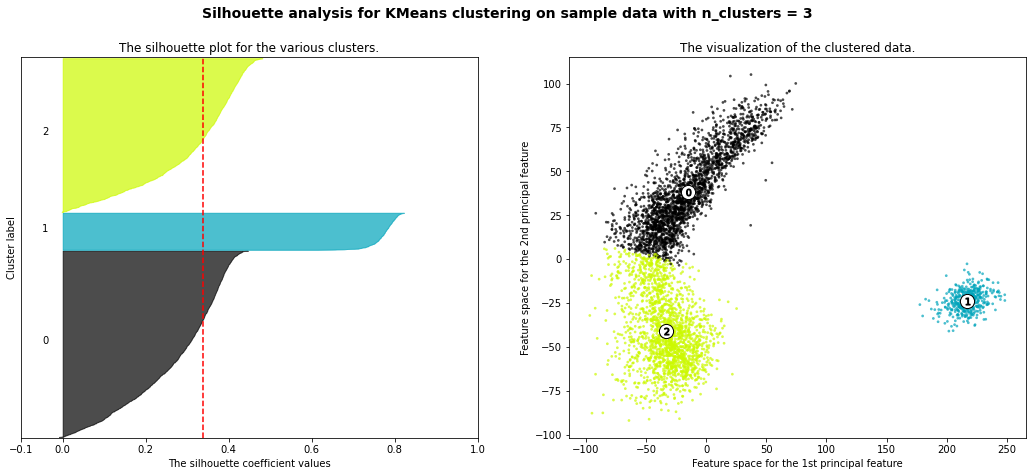

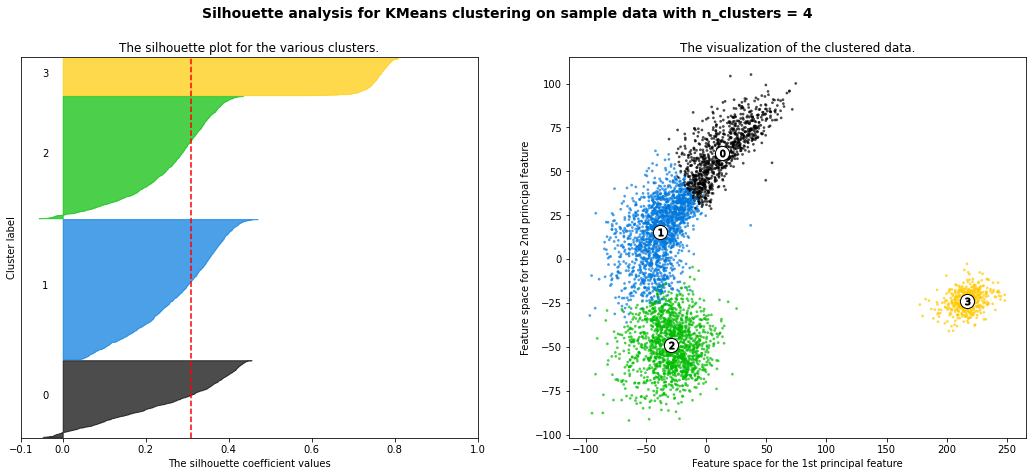

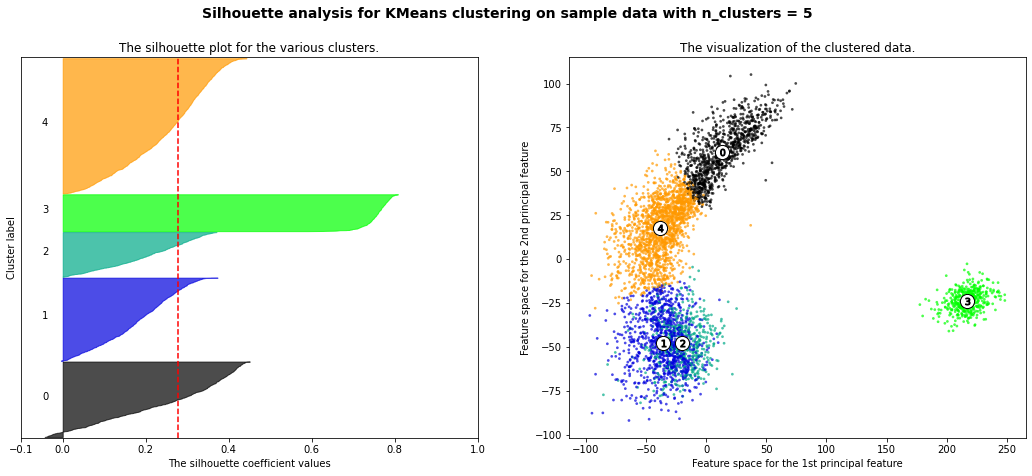

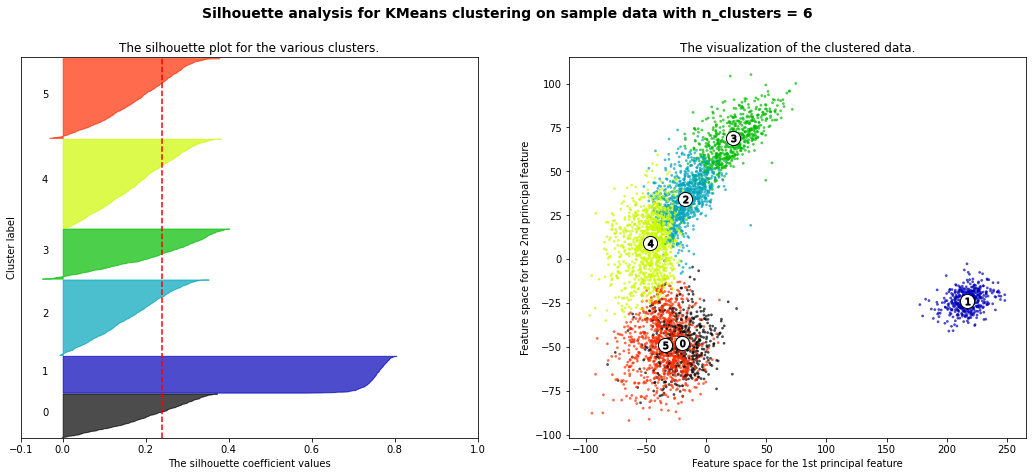

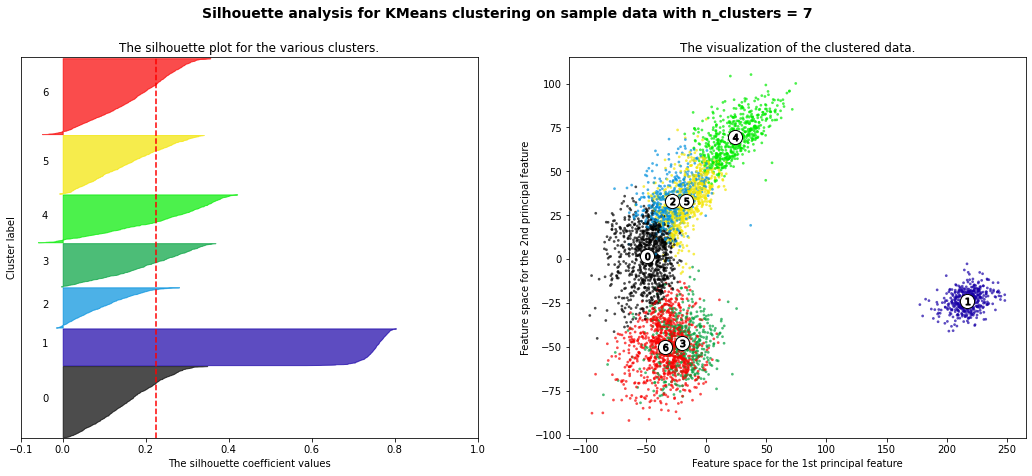

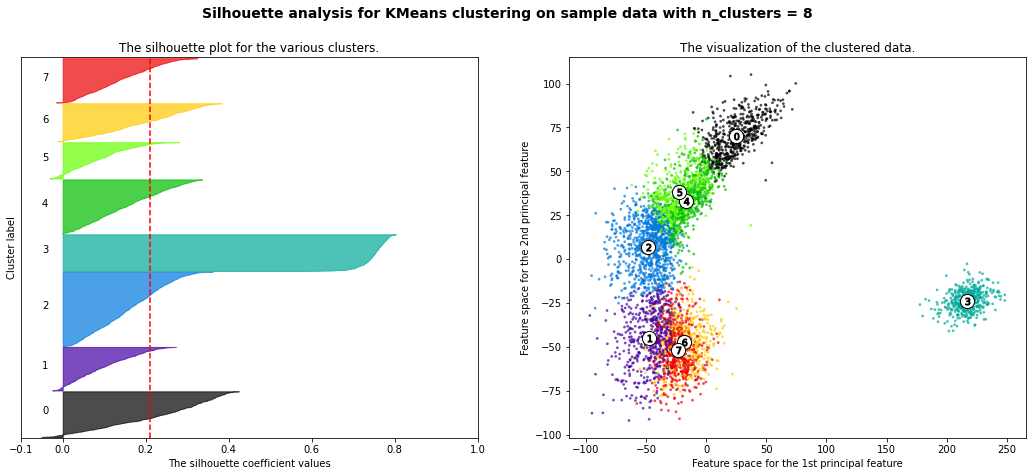

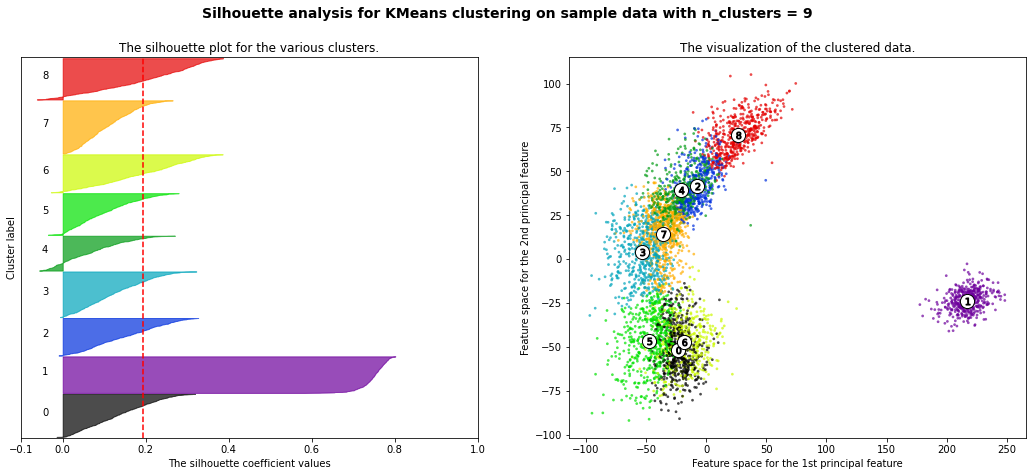

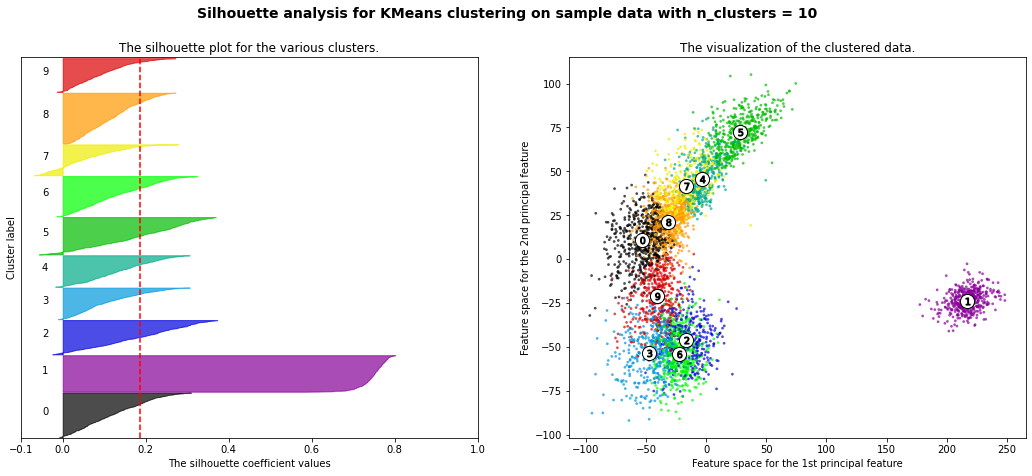

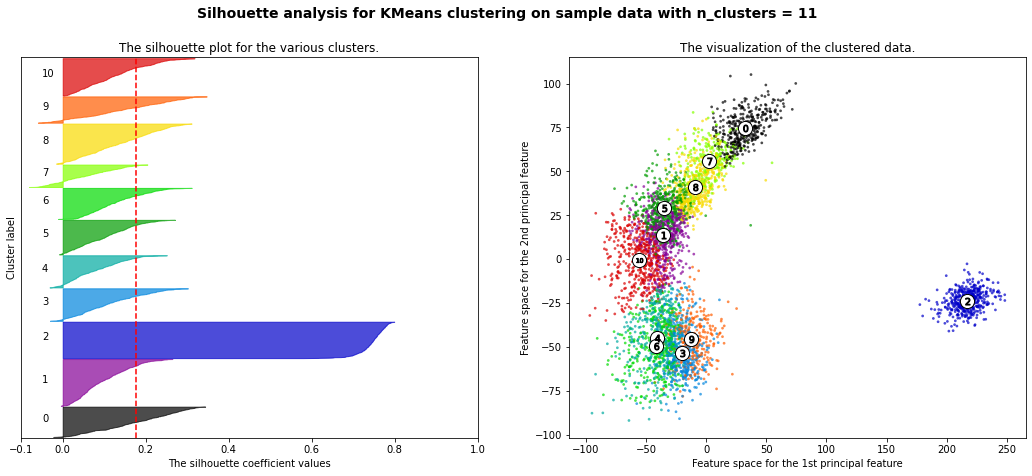

In [29]:
K = range(2,12)

for k in K:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df_skills) + (k + 1) * 10])

    clusterer = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = clusterer.fit_predict(df_skills)

    silhouette_avg = silhouette_score(df_skills, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_skills, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    pca = PCA(n_components=2)
    pca.fit(df_skills)
    X = pca.transform(df_skills)

    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    pca_centers = pca.transform(clusterer.cluster_centers_)
    # Draw white circles at cluster centers
    ax2.scatter(pca_centers[:, 0], pca_centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(pca_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st principal feature")
    ax2.set_ylabel("Feature space for the 2nd principal feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

plt.show()

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
dist = 1 - cosine_similarity(df_skills)

pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
X_PCA.shape

(4512, 2)

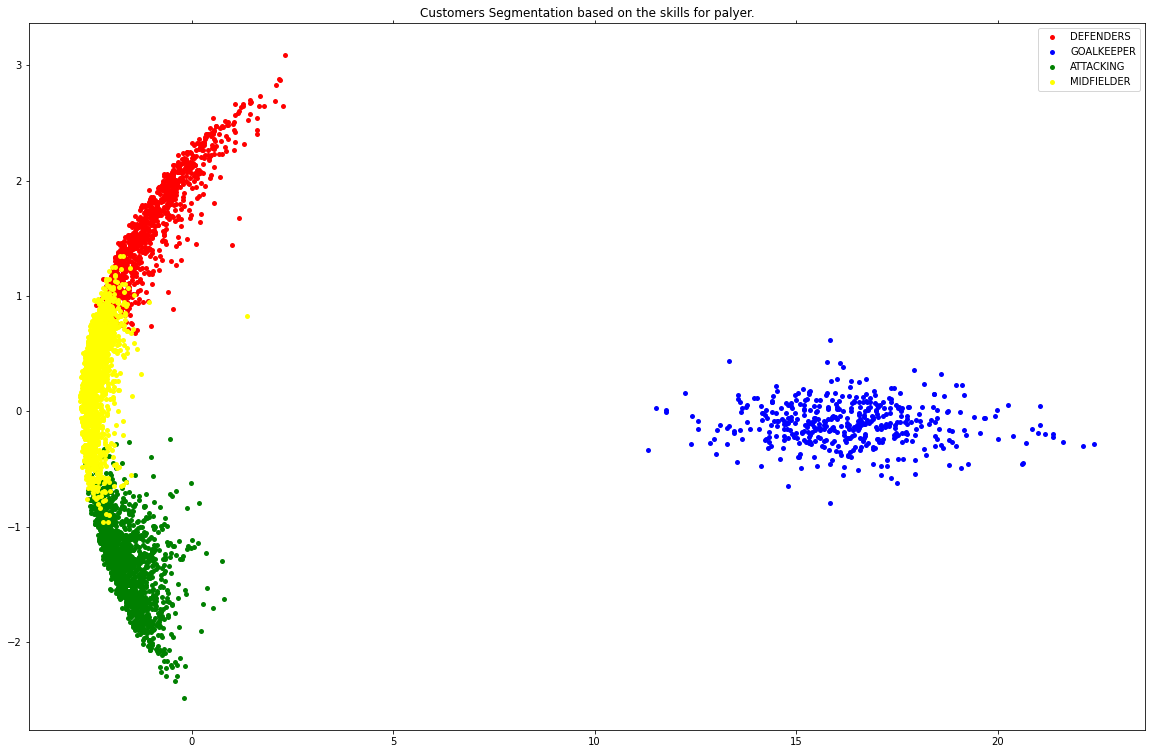

In [31]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow'}

names = {0: 'DEFENDERS', 
         1: 'GOALKEEPER', 
         2: 'ATTACKING', 
         3: 'MIDFIELDER'}
  
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("Customers Segmentation based on the skills for palyer.")
plt.show()

Gráficando en dos componentes podemos visualizar como quedan difenciados los 4 grupos de jugadores

# 4.-Clustering-Mean-Shift 

- NO es necesario definirle la cantidad de grupos/clusters
- NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
- Hipeparámetros: radio/bandwith (de cobertura para cálculo de media). (Probar con varios)

In [32]:
ms = MeanShift(bandwidth=2, bin_seeding=True)

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 3


Graficamos los resultados:

In [33]:
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

In [34]:
data=[]
MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [35]:
#En Colab
#fig.show(renderer="colab")
iplot(fig)

In [36]:
df_clusters['MeanShift'] = ms.labels_ #ms.labels_ #clusters2
print('Kmeans encontró: ', max(labels)+1, 'clusters, nosotros lo forzamos') #km.labels_
print('Mean shift encontró ', max(ms.labels_)+1, 'clusters, según los hiperparámetros elegidos') #km.labels_

Kmeans encontró:  4 clusters, nosotros lo forzamos
Mean shift encontró  3 clusters, según los hiperparámetros elegidos


**EVALUACIÓN**

**EJERCICIO EN GRUPO: Análisis exploratorio de los clusters, usando las clases asignadas por MeanShift** 

- Cantidad de observaciones por Cluster
- Análisis descriptivo separando por Cluster
- Tabla de contingencia alguna categórica vs clusters
- Silohuette?

**Cantidad de observaciones por Cluster**

In [37]:
df_clusters.MeanShift.value_counts()

0    1975
2    1599
1     938
Name: MeanShift, dtype: int64

Se advierte que el Cluster con mayor cantidad de casos es el 0, contando con 1975 jugadores, seguido por el 2 con 1599 jugadores. Por último, el Cluster 3 agrupa 938 jugadores.

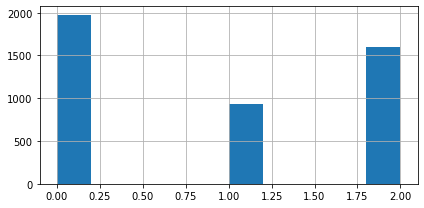

In [38]:
df_clusters.MeanShift.hist(figsize=(6, 3))
plt.tight_layout()

**Pregunta: normalizamos/estandarizamos la base?**

En este caso, no es necesario entandarizar las variables (eg. skills) debido a que todas ellas se encuentran entre valores que van del 0 al 100

**Análisis descriptivo separando por Cluster**

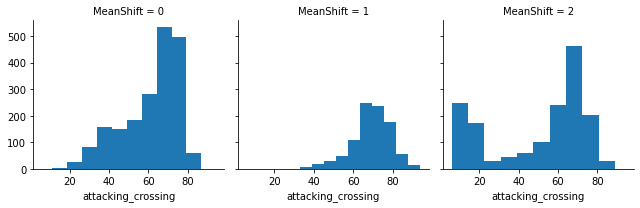

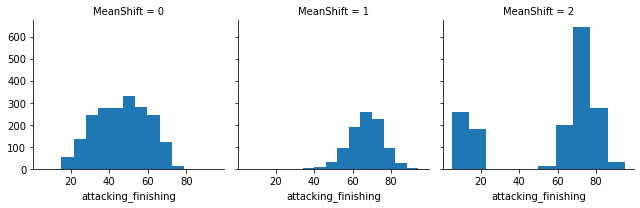

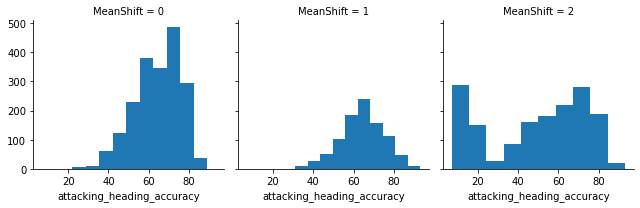

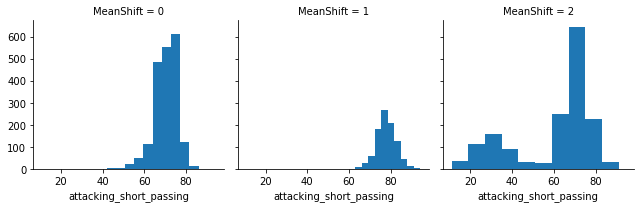

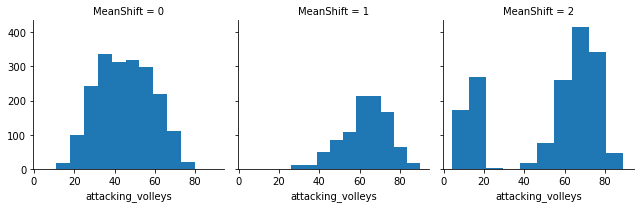

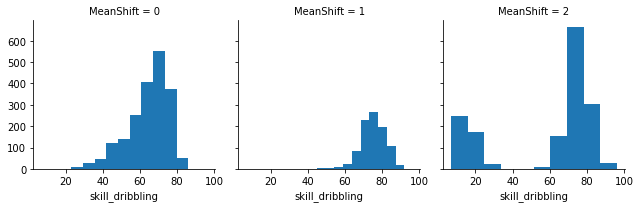

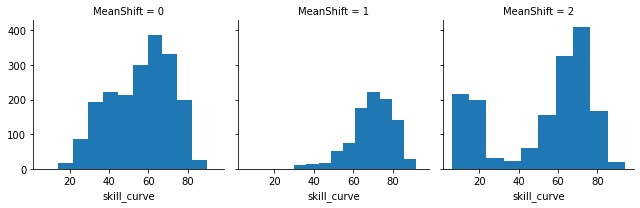

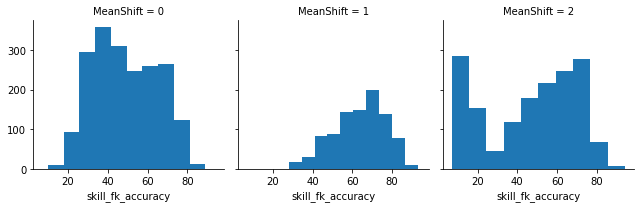

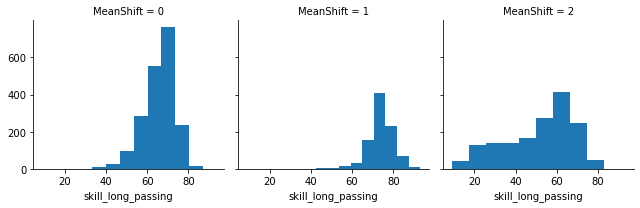

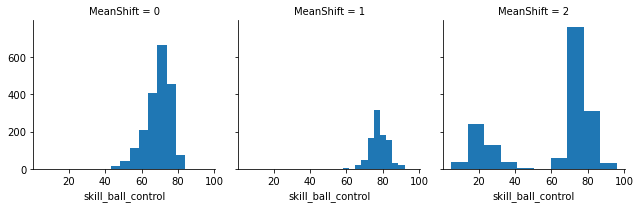

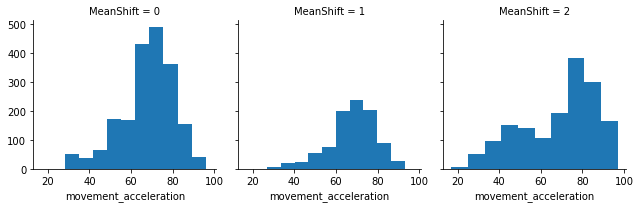

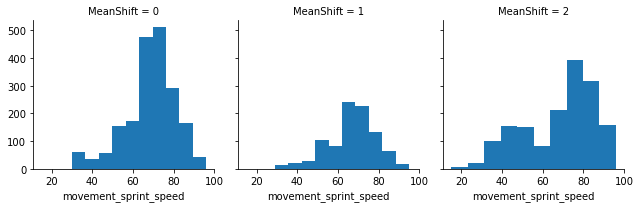

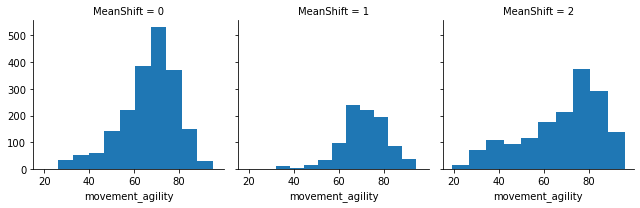

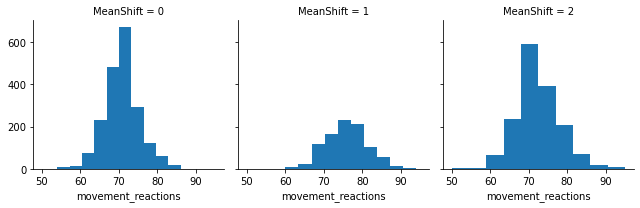

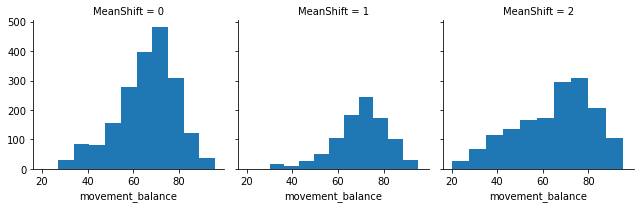

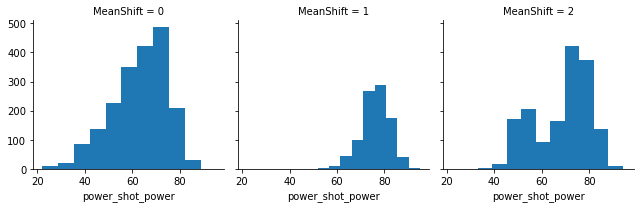

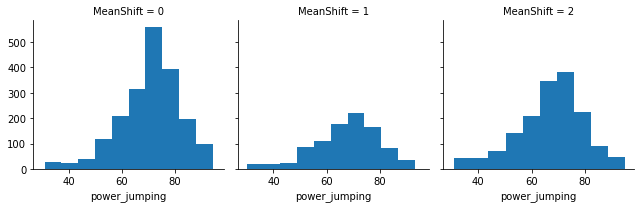

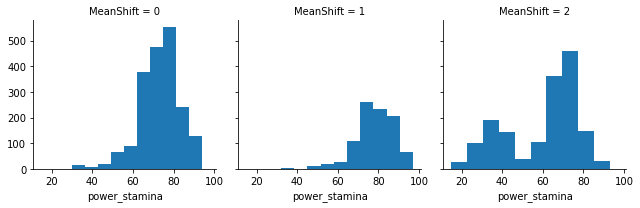

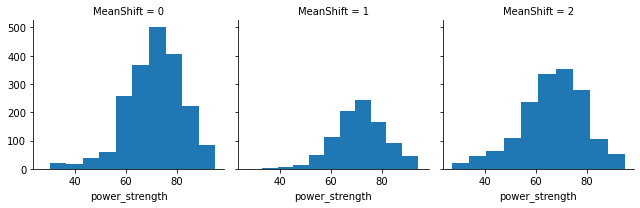

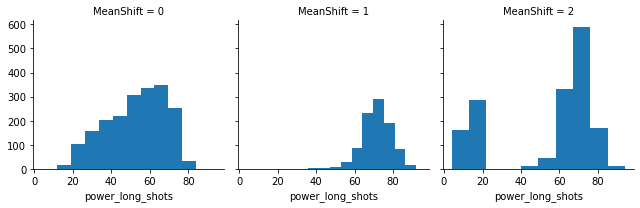

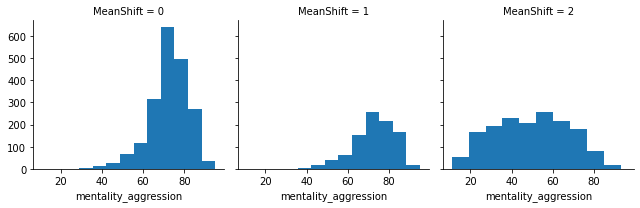

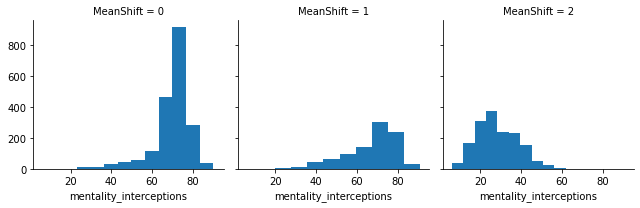

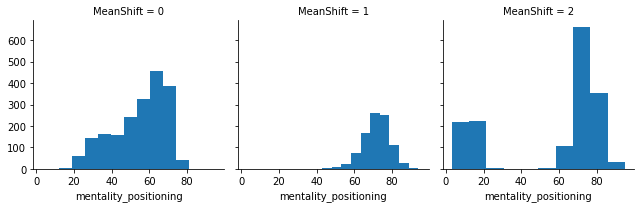

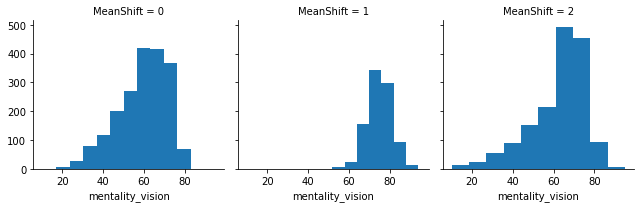

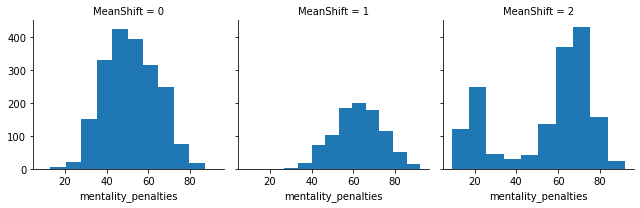

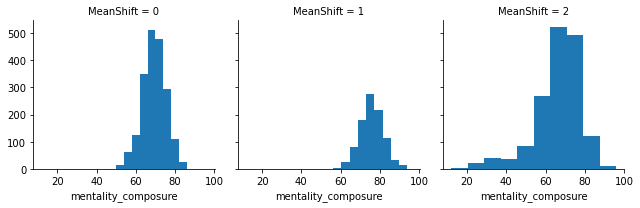

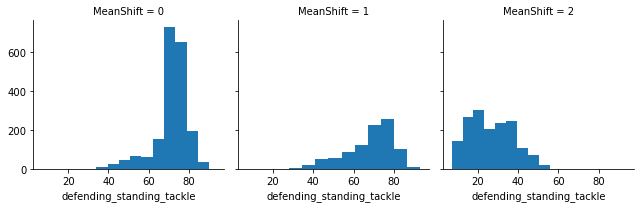

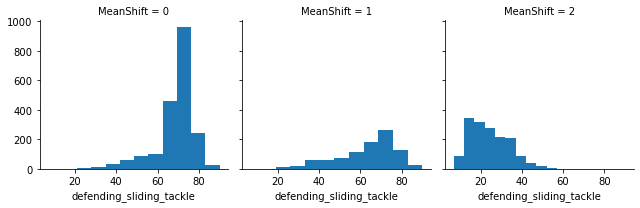

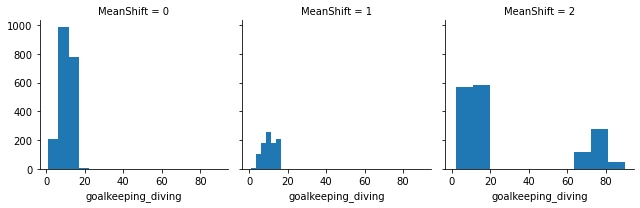

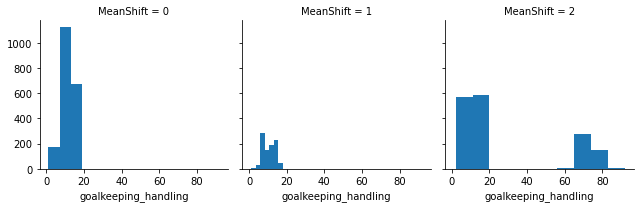

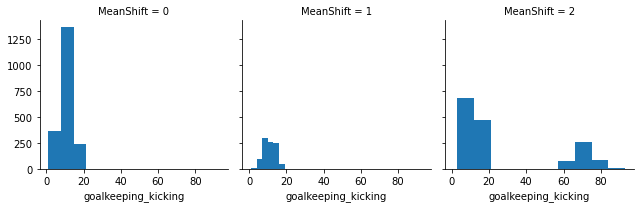

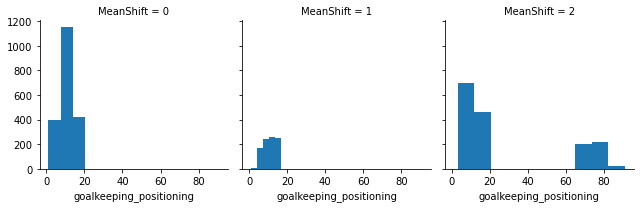

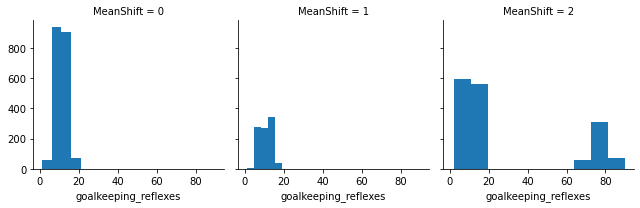

In [39]:
for c in df_clusters[skills_ratings]:
    grid = sns.FacetGrid(df_clusters, col='MeanShift')
    grid.map(plt.hist, c)

In [40]:
df_clusters_0=df_clusters[df_clusters["MeanShift"]==0]
df_clusters_0.describe()

sofifa_id          age    height_cm    weight_kg  league_rank  \
count    1975.000000  1975.000000  1975.000000  1975.000000  1930.000000   
mean   212806.134684    27.255696   181.098734    75.707848     1.122280   
std     23814.289097     3.998852     6.662426     6.939762     0.333962   
min     20209.000000    17.000000   163.000000    55.000000     1.000000   
25%    199240.000000    24.000000   176.000000    70.000000     1.000000   
50%    214906.000000    27.000000   181.000000    75.000000     1.000000   
75%    230432.500000    30.000000   186.000000    80.000000     1.000000   
max    258370.000000    42.000000   199.000000   101.000000     3.000000   

           overall    potential     value_eur       wage_eur  \
count  1975.000000  1975.000000  1.975000e+03    1975.000000   
mean     73.816709    76.252658  5.314291e+06   20366.075949   
std       2.762431     4.109132  4.634999e+06   20650.052892   
min      71.000000    71.000000  0.000000e+00       0.000000   
25%      72.000000    73.000000  2.700000e+06    8000.000000   
50%      73.000000    75.000000  4.000000e+06   15000.000000   
75%      75.000000    79.000000  6.500000e+06   26000.000000   
max      88.000000    91.000000  5.000000e+07  220000.000000   

       international_reputation    weak_foot  skill_moves  release_clause_eur  \
count               1975.000000  1975.000000  1975.000000        1.852000e+03   
mean                   1.221266     2.984304     2.613671        1.045172e+07   
std                    0.497362     0.656398     0.627078        9.277094e+06   
min                    1.000000     1.000000     2.000000        6.160000e+05   
25%                    1.000000     3.000000     2.000000        5.000000e+06   
50%                    1.000000     3.000000     3.000000        7.700000e+06   
75%                    1.000000     3.000000     3.000000        1.280000e+07   
max                    4.000000     5.000000     5.000000        9.880000e+07   

       team_jersey_number  contract_valid_until  nation_jersey_number  \
count         1930.000000           1930.000000            283.000000   
mean            17.330052           2022.206218             10.049470   
std             15.423195              1.182191              6.663468   
min              2.000000           2020.000000              2.000000   
25%              5.000000           2021.000000              4.000000   
50%             15.000000           2022.000000              7.000000   
75%             24.000000           2023.000000             16.000000   
max             98.000000           2027.000000             23.000000   

              pace     shooting      passing    dribbling    defending  \
count  1975.000000  1975.000000  1975.000000  1975.000000  1975.000000   
mean     68.183797    51.617215    63.842025    66.532152    69.370127   
std      12.124236    11.804053     7.979289     8.668840     8.587839   
min      30.000000    18.000000    35.000000    34.000000    32.000000   
25%      62.000000    43.000000    59.000000    62.000000    67.000000   
50%      70.000000    52.000000    65.000000    69.000000    71.000000   
75%      76.000000    61.000000    70.000000    73.000000    74.000000   
max      96.000000    78.000000    82.000000    84.000000    90.000000   

            physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  gk_speed  \
count  1975.000000        0.0          0.0         0.0          0.0       0.0   
mean     71.830886        NaN          NaN         NaN          NaN       NaN   
std       6.919845        NaN          NaN         NaN          NaN       NaN   
min      41.000000        NaN          NaN         NaN          NaN       NaN   
25%      68.000000        NaN          NaN         NaN          NaN       NaN   
50%      73.000000        NaN          NaN         NaN          NaN       NaN   
75%      77.000000        NaN          NaN         NaN          NaN       NaN   
max      91.000000        NaN          NaN    

In [41]:
df_clusters_0=df_clusters[df_clusters["MeanShift"]==1]
df_clusters_0.describe()

sofifa_id         age   height_cm   weight_kg  league_rank  \
count     938.000000  938.000000  938.000000  938.000000   929.000000   
mean   205028.035181   27.816631  181.026652   75.607676     1.057051   
std     26340.792545    3.880342    6.050158    6.375114     0.236662   
min        41.000000   17.000000  158.000000   56.000000     1.000000   
25%    190420.000000   25.000000  177.000000   71.000000     1.000000   
50%    206358.500000   28.000000  181.000000   75.000000     1.000000   
75%    224068.500000   31.000000  185.000000   80.000000     1.000000   
max    258262.000000   39.000000  201.000000  100.000000     3.000000   

          overall   potential     value_eur       wage_eur  \
count  938.000000  938.000000  9.380000e+02     938.000000   
mean    76.961620   78.855011  1.139667e+07   42058.102345   
std      3.985917    4.621914  1.084782e+07   45874.173455   
min     71.000000   71.000000  0.000000e+00       0.000000   
25%     74.000000   75.000000  4.725000e+06   14250.000000   
50%     76.000000   78.000000  8.000000e+06   27000.000000   
75%     79.000000   82.000000  1.350000e+07   52000.000000   
max     91.000000   92.000000  8.700000e+07  370000.000000   

       international_reputation   weak_foot  skill_moves  release_clause_eur  \
count                938.000000  938.000000   938.000000        9.110000e+02   
mean                   1.630064    3.319829     3.202559        2.194605e+07   
std                    0.815166    0.691503     0.629677        2.128760e+07   
min                    1.000000    1.000000     2.000000        7.500000e+05   
25%                    1.000000    3.000000     3.000000        8.550000e+06   
50%                    1.000000    3.000000     3.000000        1.580000e+07   
75%                    2.000000    4.000000     4.000000        2.570000e+07   
max                    5.000000    5.000000     5.000000        1.610000e+08   

       team_jersey_number  contract_valid_until  nation_jersey_number  \
count          929.000000            929.000000            224.000000   
mean            17.443488           2022.411195             12.821429   
std             13.653158              1.213663              6.051667   
min              2.000000           2020.000000              2.000000   
25%              8.000000           2021.000000              8.000000   
50%             15.000000           2022.000000             13.000000   
75%             22.000000           2023.000000             18.000000   
max             99.000000           2026.000000             26.000000   

             pace    shooting     passing   dribbling   defending      physic  \
count  938.000000  938.000000  938.000000  938.000000  938.000000  938.000000   
mean    67.353945   69.255864   73.783582   75.268657   66.051173   72.963753   
std     11.161973    6.574148    5.351774    5.619973   11.206681    7.057075   
min     30.000000   46.000000   51.000000   53.000000   24.000000   45.000000   
25%     62.000000   65.000000   71.000000   72.000000   59.000000   69.000000   
50%     68.000000   69.000000   74.000000   75.000000   69.000000   74.000000   
75%     75.000000   74.000000   77.000000   79.000000   74.000000   77.000000   
max     94.000000   91.000000   93.000000   92.000000   91.000000   91.000000   

       gk_diving  gk_handling  gk_kicking  gk_reflexes  gk_speed  \
count        0.0          0.0         0.0          0.0       0.0   
mean         NaN          NaN         NaN          NaN       NaN   
std          NaN          NaN         NaN          NaN       NaN   
min          NaN          NaN         NaN          NaN       NaN   
25%          NaN          NaN         NaN          NaN       NaN   
50%          NaN          NaN         NaN          NaN       NaN   
75%          NaN          NaN         NaN          NaN       NaN   
max          NaN          NaN         NaN          NaN       NaN   

       gk_positioning  attacking_crossing  attacking_finishing  \
count 

In [42]:
df_clusters_0=df_clusters[df_clusters["MeanShift"]==2]
df_clusters_0.describe()

sofifa_id          age    height_cm    weight_kg  league_rank  \
count    1599.000000  1599.000000  1599.000000  1599.000000  1564.000000   
mean   208992.606629    27.673546   181.972483    77.081301     1.099105   
std     30061.435991     4.336848     7.697292     8.045919     0.301031   
min      1179.000000    17.000000   157.000000    56.000000     1.000000   
25%    194136.500000    24.000000   176.000000    71.000000     1.000000   
50%    213490.000000    28.000000   182.000000    77.000000     1.000000   
75%    230276.500000    31.000000   188.000000    83.000000     1.000000   
max    257189.000000    42.000000   203.000000   104.000000     3.000000   

           overall    potential     value_eur       wage_eur  \
count  1599.000000  1599.000000  1.599000e+03    1599.000000   
mean     74.916823    77.138837  7.774859e+06   25715.759850   
std       3.750506     4.867273  9.732209e+06   36065.469974   
min      71.000000    71.000000  0.000000e+00       0.000000   
25%      72.000000    73.000000  3.000000e+06    8000.000000   
50%      74.000000    76.000000  4.900000e+06   16000.000000   
75%      77.000000    80.000000  9.000000e+06   31000.000000   
max      93.000000    95.000000  1.055000e+08  560000.000000   

       international_reputation    weak_foot  skill_moves  release_clause_eur  \
count               1599.000000  1599.000000  1599.000000        1.496000e+03   
mean                   1.352095     3.185741     2.702939        1.527987e+07   
std                    0.661270     0.789415     1.174909        1.928060e+07   
min                    1.000000     1.000000     1.000000        3.240000e+05   
25%                    1.000000     3.000000     1.000000        5.500000e+06   
50%                    1.000000     3.000000     3.000000        9.400000e+06   
75%                    2.000000     4.000000     4.000000        1.790000e+07   
max                    5.000000     5.000000     5.000000        2.031000e+08   

       team_jersey_number  contract_valid_until  nation_jersey_number  \
count         1564.000000           1564.000000            283.000000   
mean            18.148338           2022.267903             12.908127   
std             17.823827              1.270450              6.837945   
min              1.000000           2020.000000              1.000000   
25%              9.000000           2021.000000              9.000000   
50%             13.000000           2022.000000             12.000000   
75%             22.000000           2023.000000             19.000000   
max             99.000000           2028.000000             27.000000   

              pace     shooting      passing    dribbling    defending  \
count  1155.000000  1155.000000  1155.000000  1155.000000  1155.000000   
mean     77.228571    72.079654    66.417316    75.292641    35.050216   
std       9.874062     5.311173     6.964558     5.391363     6.438019   
min      30.000000    54.000000    44.000000    58.000000    18.000000   
25%      72.000000    69.000000    62.000000    72.000000    30.000000   
50%      78.000000    72.000000    67.000000    75.000000    35.000000   
75%      84.000000    75.000000    71.000000    79.000000    40.000000   
max      96.000000    93.000000    91.000000    95.000000    56.000000   

            physic   gk_diving  gk_handling  gk_kicking  gk_reflexes  \
count  1155.000000  444.000000   444.000000  444.000000   444.000000   
mean     65.645887   75.594595    72.664414   70.373874    77.060811   
std       9.197061    4.497561     4.683432    6.085163     4.657904   
min      37.000000   61.000000    62.000000   44.000000    66.000000   
25%      60.000000   72.000000    69.000000   66.000000    74.000000   
50%      66.000000   75.000000    72.000000   70.000000    76.000000   
75%      72.000000   78.000000    76.000000   74.000000    80.000000   
max      90.000000   90.000000    92.000000   93.000000    90.000000   

         gk_speed  gk_positioning  attacking_

Hay una diferencia entre grupos en relación a la variable salario y reputación. El cluster 1 incluyó jugadores con mayores sueldos, seguido por el cluster 2 y por último por el cluster 3. 

In [43]:
df_clusters.groupby(['MeanShift'])[skills_ratings].mean()

attacking_crossing  attacking_finishing  \
MeanShift                                            
0                   61.252658            46.298734   
1                   69.270789            66.382729   
2                   50.417761            56.383990   

           attacking_heading_accuracy  attacking_short_passing  \
MeanShift                                                        
0                           64.241519                70.300253   
1                           64.157783                77.849680   
2                           48.883052                59.509068   

           attacking_volleys  skill_dribbling  skill_curve  skill_fk_accuracy  \
MeanShift                                                                       
0                  45.352911        64.598481    56.056709          48.951899   
1                  63.093817        75.199360    69.513859          63.384861   
2                  52.229518        58.849281    52.368355          46.394622   

           skill_long_passing  skill_ball_control  movement_acceleration  \
MeanShift                                                                  
0                   65.699241           68.982278              67.792911   
1                   74.074627           77.638593              67.811301   
2                   51.423390           60.783615              68.294559   

           movement_sprint_speed  movement_agility  movement_reactions  \
MeanShift                                                                
0                      68.474937         66.809114           70.671392   
1                      66.973348         70.962687           75.696162   
2                      67.995622         68.140713           72.037523   

           movement_balance  power_shot_power  power_jumping  power_stamina  \
MeanShift                                                                     
0                 65.961519         63.145316      70.584304      73.038987   
1                 69.704691         75.997868      67.360341      77.905117   
2                 64.584740         68.573483      66.882427      59.966854   

           power_strength  power_long_shots  mentality_aggression  \
MeanShift                                                           
0               70.981266         52.675443             72.641013   
1               71.199360         71.448827             72.479744   
2               66.540338         53.803002             49.427767   

           mentality_interceptions  mentality_positioning  mentality_vision  \
MeanShift                                                                     
0                        69.693671              54.986329         59.262278   
1                        67.231343              71.719616         74.478678   
2                        28.318949              57.267667         62.316448   

           mentality_penalties  mentality_composure  \
MeanShift                                             
0                    51.626835            68.788354   
1                    62.131130            75.719616   
2                    54.649781            66.275797   

           defending_standing_tackle  defending_sliding_tackle  \
MeanShift                                                        
0                          71.273924                 69.087595   
1                          67.700426                 63.119403   
2                          26.316448                 23.622889   

           goalkeeping_diving  goalkeeping_handling  goalkeeping_kicking  \
MeanShift                                                                  
0                   10.615696             10.836456            10.787342   
1                   10.535181             10.454158            10.531983   
2                   28.623515             27.834271            27.232020   

           goalkeeping_positioning  goalkeeping_reflexes  
MeanShift                                                 
0      

**Observaciones**

Cluster 0: Reune jugadores defensivos con jugadores del medio campo.

Cluster 1: Agrupa a los jugadores de medio campo.

Cluster 2: Agrupa a los arqueros con jugadores ofencibos.

**Tabla de contingencia alguna categórica vs clusters**

In [44]:
df_clusters.groupby(['preferred_foot','MeanShift'])['MeanShift'].count()

preferred_foot  MeanShift
Left            0             606
                1             222
                2             326
Right           0            1369
                1             716
                2            1273
Name: MeanShift, dtype: int64

<AxesSubplot:xlabel='MeanShift', ylabel='Percent'>

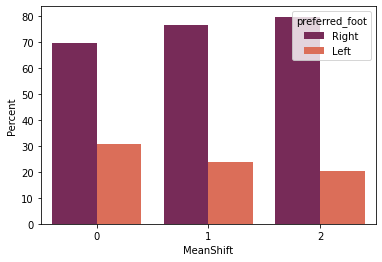

In [45]:
df_aux = df_clusters.groupby(['MeanShift'])['preferred_foot'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
sns.barplot(x='MeanShift', y='Percent', hue='preferred_foot', data=df_aux, palette='rocket')

Podemos observar que la mayoria de los jugadores son derechos. Y en el cluster 0 mas zurdos que en el claste 1 y 2.

**Silhouette**

In [46]:
ms = MeanShift(bandwidth=2, bin_seeding=True)
ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(df_skills, clusters2))

Cantidad de clusters encontrados por Mean Shift : 3
Silhouette Coefficient: 0.045


In [47]:
ms = MeanShift(bandwidth=2, bin_seeding=True)
ms.fit(df_skills)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

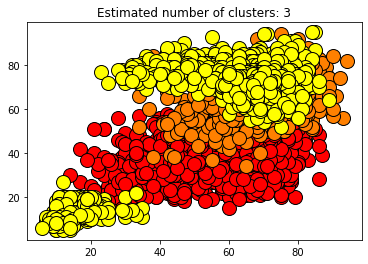

In [48]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.autumn(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    cluster_center = cluster_centers[k]

    xy = df_skills[class_member_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
    
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

**Ahora vemos que agrupamientos se pueden hacer excluyendo los arqueros**

# 5.-Clustering-con-Kmeans-sin-arqueros

In [49]:
df=pd.read_csv("players_21.csv")

In [50]:
#df.player_positions.value_counts()

In [51]:
n=10000
df_n=df.loc[:n]
df_n=df_n[(df_n["player_positions"].apply(lambda rou:'GK' not in rou))&(df_n["overall"]>69)] ##player_positions

skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
                  'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
                  'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions',
                  'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
                  'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 
                'mentality_composure', 'defending_standing_tackle', 'defending_sliding_tackle']

df_skills=df_n[skills_ratings]


Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

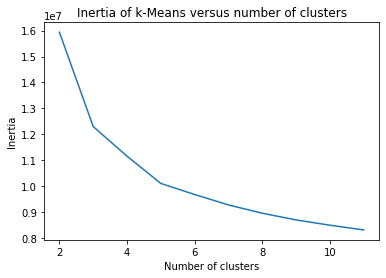

In [52]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

A partir del gráfico de codo podemos observar que el número ótimo de clusters es 3. A continuación se ajustará el modelo con esta cantidad de clusters.

In [53]:
# Número de clusters buscado
n_clust = 3

km = KMeans(n_clusters=n_clust)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_

In [54]:
#data=[]
bool_crack=df_n['overall'] > 85
bool_no_crack=df_n['overall']<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

In [55]:
kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

In [56]:
#En Colab
#fig.show(renderer="colab")

In [57]:
#en Jupyter:
iplot(fig)

In [58]:
df_clusters=df_n.copy()
labels = km.labels_
df_clusters['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  3 clusters, nosotros forzamos la cantidad


**Cantidad de observaciones por Cluster**

In [59]:
df_clusters.kmeans.value_counts()

1    1987
0    1753
2    1129
Name: kmeans, dtype: int64

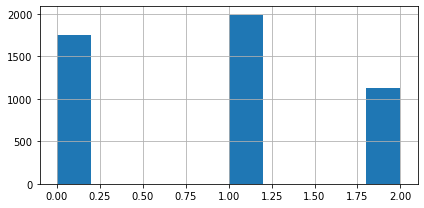

In [60]:
df_clusters.kmeans.hist(figsize=(6, 3))
plt.tight_layout()

Se advierte que el Cluster con mayor cantidad de casos es el 2, contando con 1979 jugadores, seguido por el 1 con 1746 jugadores. Por último, el Cluster 0 agrupa 1144 jugadores.

**Análisis descriptivo separando por Cluster**

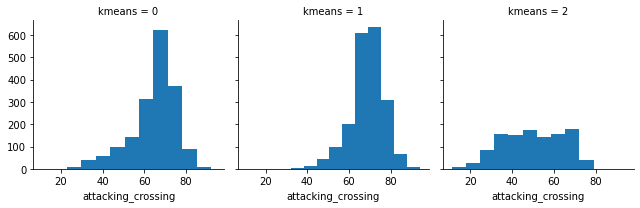

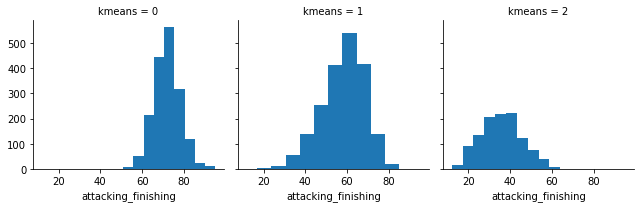

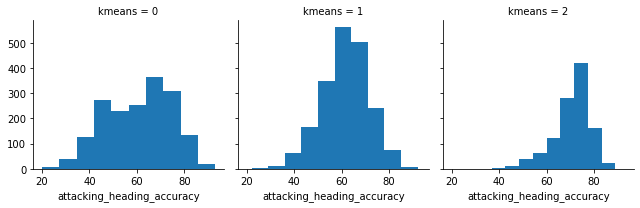

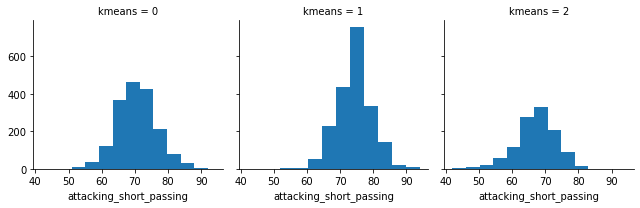

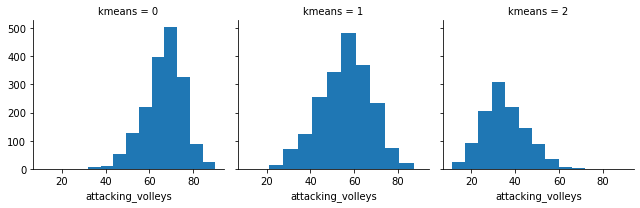

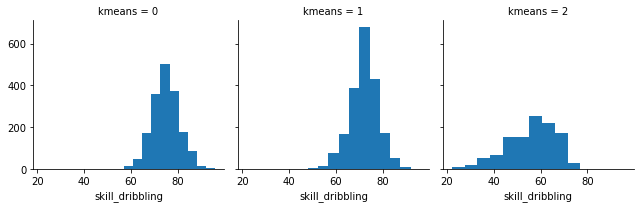

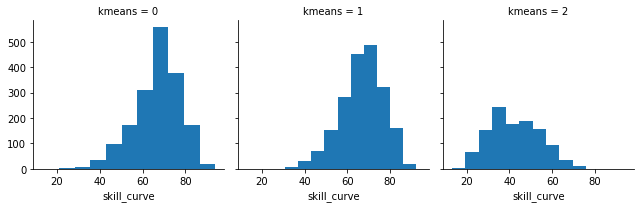

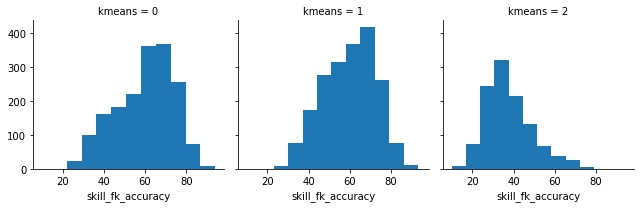

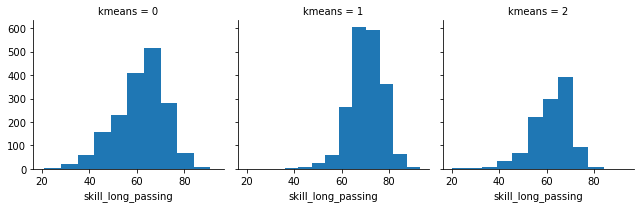

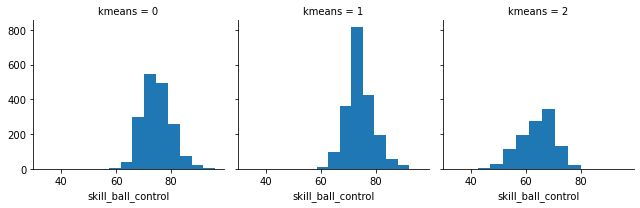

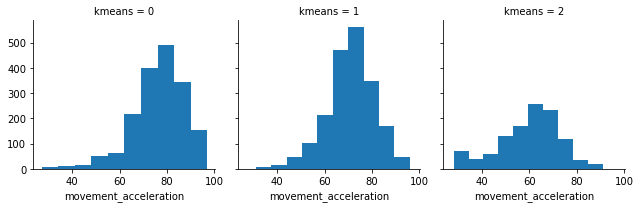

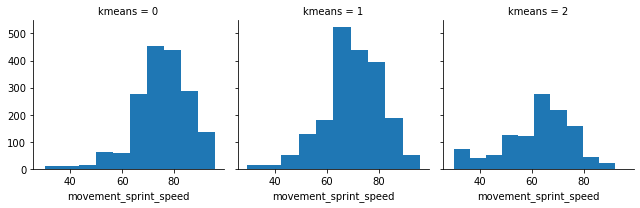

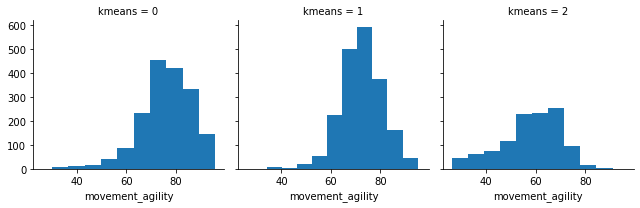

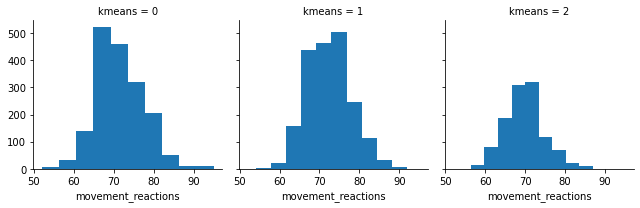

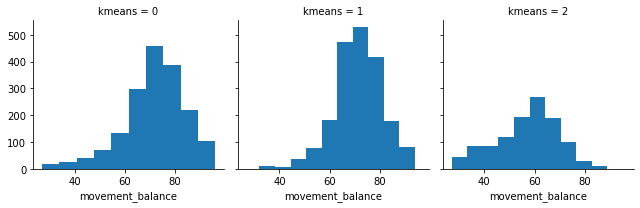

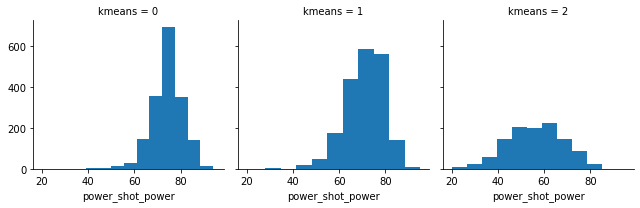

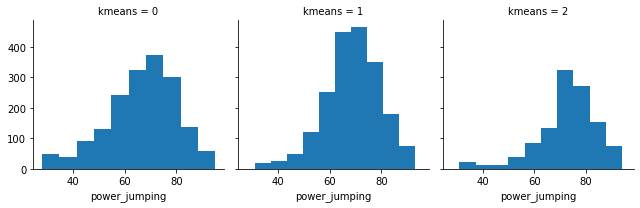

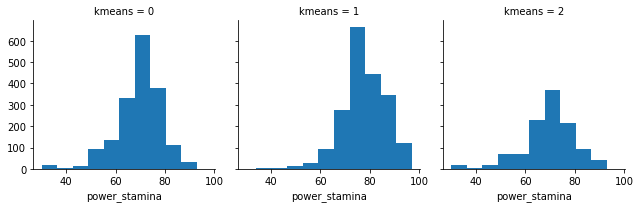

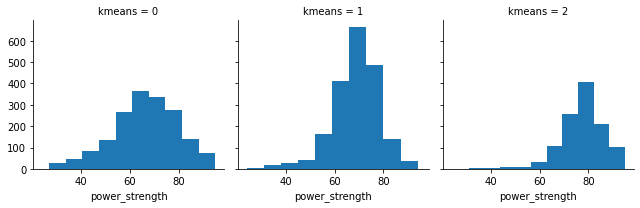

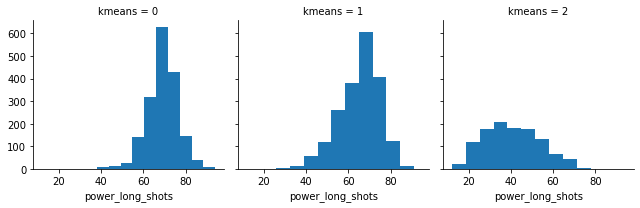

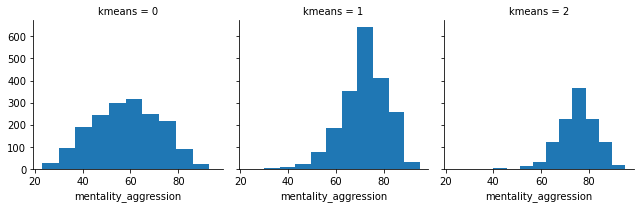

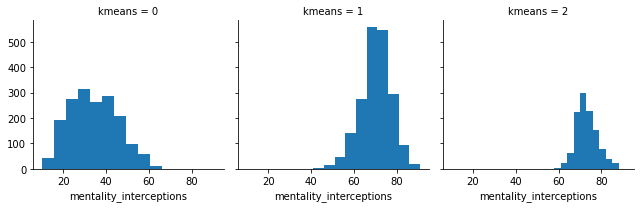

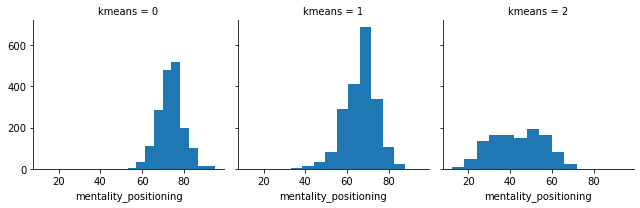

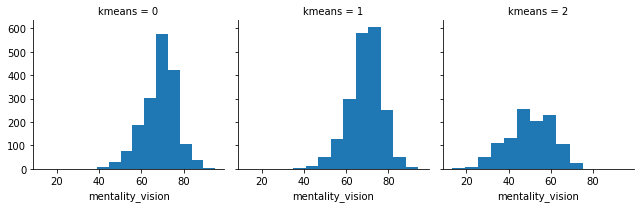

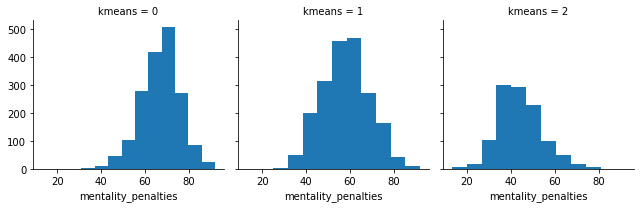

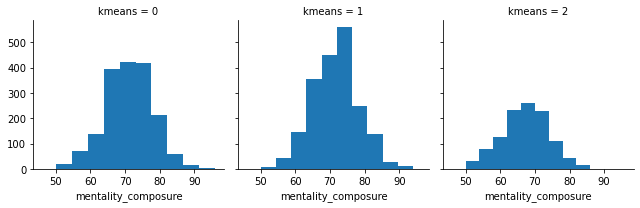

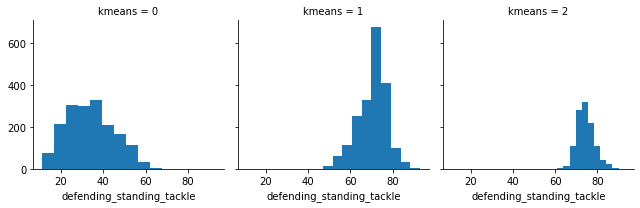

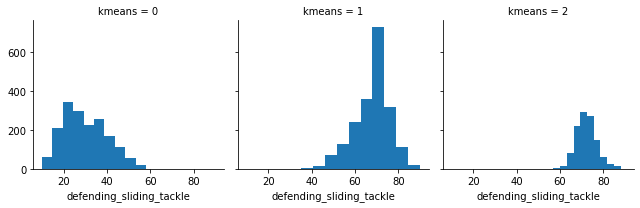

In [61]:
for c in df_clusters[skills_ratings]:
    grid = sns.FacetGrid(df_clusters, col='kmeans')
    grid.map(plt.hist, c)

In [62]:
df_clusters_0=df_clusters[df_clusters["kmeans"]==0]
df_clusters_0.describe()

sofifa_id          age    height_cm    weight_kg  league_rank  \
count    1753.000000  1753.000000  1753.000000  1753.000000  1720.000000   
mean   212368.315459    27.077011   179.055334    74.211637     1.115116   
std     27063.893925     4.084482     6.748314     7.156537     0.321072   
min      3467.000000    17.000000   157.000000    56.000000     1.000000   
25%    199069.000000    24.000000   174.000000    69.000000     1.000000   
50%    215103.000000    27.000000   179.000000    74.000000     1.000000   
75%    230857.000000    30.000000   184.000000    79.000000     1.000000   
max    258262.000000    40.000000   201.000000   104.000000     3.000000   

           overall    potential     value_eur       wage_eur  \
count  1753.000000  1753.000000  1.753000e+03    1753.000000   
mean     74.072447    76.395322  7.358485e+06   25207.073588   
std       3.848278     4.997547  9.401268e+06   36338.349526   
min      70.000000    70.000000  0.000000e+00       0.000000   
25%      71.000000    72.000000  2.500000e+06    8000.000000   
50%      73.000000    75.000000  4.300000e+06   15000.000000   
75%      76.000000    80.000000  8.500000e+06   30000.000000   
max      93.000000    95.000000  1.055000e+08  560000.000000   

       international_reputation    weak_foot  skill_moves  release_clause_eur  \
count               1753.000000  1753.000000  1753.000000        1.642000e+03   
mean                   1.340559     3.352539     3.328009        1.439291e+07   
std                    0.667103     0.705544     0.616735        1.848230e+07   
min                    1.000000     1.000000     2.000000        7.190000e+05   
25%                    1.000000     3.000000     3.000000        4.800000e+06   
50%                    1.000000     3.000000     3.000000        8.400000e+06   
75%                    1.000000     4.000000     4.000000        1.680000e+07   
max                    5.000000     5.000000     5.000000        2.031000e+08   

       team_jersey_number  contract_valid_until  nation_jersey_number  \
count         1720.000000           1720.000000            260.000000   
mean            18.759884           2022.272674             14.123077   
std             16.332386              1.282884              5.173463   
min              2.000000           2020.000000              3.000000   
25%              9.000000           2021.000000             10.000000   
50%             14.000000           2022.000000             14.000000   
75%             22.000000           2023.000000             19.000000   
max             99.000000           2028.000000             27.000000   

              pace     shooting      passing    dribbling    defending  \
count  1753.000000  1753.000000  1753.000000  1753.000000  1753.000000   
mean     75.681689    71.350257    66.851683    74.693098    37.091843   
std      10.294587     5.490181     7.351942     5.424181     7.923082   
min      30.000000    54.000000    44.000000    57.000000    18.000000   
25%      70.000000    68.000000    62.000000    71.000000    31.000000   
50%      77.000000    71.000000    67.000000    75.000000    37.000000   
75%      82.000000    75.000000    72.000000    78.000000    43.000000   
max      96.000000    93.000000    91.000000    95.000000    60.000000   

            physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  gk_speed  \
count  1753.000000        0.0          0.0         0.0          0.0       0.0   
mean     65.401597        NaN          NaN         NaN          NaN       NaN   
std       9.063868        NaN          NaN         NaN          NaN       NaN   
min      37.000000        NaN          NaN         NaN          NaN       NaN   
25%      60.000000        NaN          NaN         NaN          NaN       NaN   
50%      66.000000        NaN          NaN         NaN          NaN       NaN   
75%      72.000000        NaN          NaN         NaN          NaN       NaN   
max      90.000000        NaN          NaN    

In [63]:
df_clusters_0=df_clusters[df_clusters["kmeans"]==1]
df_clusters_0.describe()

sofifa_id          age    height_cm   weight_kg  league_rank  \
count    1987.000000  1987.000000  1987.000000  1987.00000  1945.000000   
mean   211074.008556    27.342224   179.215903    73.91696     1.120308   
std     23845.279537     3.869685     5.646715     5.92498     0.334756   
min        41.000000    17.000000   163.000000    55.00000     1.000000   
25%    196925.000000    24.000000   175.000000    70.00000     1.000000   
50%    212183.000000    27.000000   179.000000    74.00000     1.000000   
75%    230187.000000    30.000000   183.000000    78.00000     1.000000   
max    258332.000000    39.000000   197.000000    96.00000     3.000000   

           overall    potential     value_eur       wage_eur  \
count  1987.000000  1987.000000  1.987000e+03    1987.000000   
mean     74.472068    76.719175  6.994389e+06   26467.035732   
std       3.776831     4.669397  7.844120e+06   33242.408146   
min      70.000000    70.000000  0.000000e+00       0.000000   
25%      71.000000    73.000000  2.500000e+06    8000.000000   
50%      74.000000    76.000000  4.700000e+06   16000.000000   
75%      77.000000    80.000000  8.500000e+06   31000.000000   
max      91.000000    92.000000  8.700000e+07  370000.000000   

       international_reputation    weak_foot  skill_moves  release_clause_eur  \
count               1987.000000  1987.000000  1987.000000        1.872000e+03   
mean                   1.324107     3.156014     2.988425        1.375746e+07   
std                    0.615867     0.685645     0.548152        1.558050e+07   
min                    1.000000     1.000000     2.000000        2.900000e+05   
25%                    1.000000     3.000000     3.000000        4.800000e+06   
50%                    1.000000     3.000000     3.000000        9.000000e+06   
75%                    2.000000     4.000000     3.000000        1.665000e+07   
max                    4.000000     5.000000     5.000000        1.610000e+08   

       team_jersey_number  contract_valid_until  nation_jersey_number  \
count         1945.000000           1945.000000            342.000000   
mean            18.045244           2022.252956             11.692982   
std             15.236375              1.201325              6.515662   
min              2.000000           2020.000000              2.000000   
25%              8.000000           2021.000000              6.000000   
50%             16.000000           2022.000000             12.000000   
75%             23.000000           2023.000000             17.000000   
max             98.000000           2026.000000             26.000000   

              pace     shooting      passing    dribbling    defending  \
count  1987.000000  1987.000000  1987.000000  1987.000000  1987.000000   
mean     70.528435    62.340211    70.458983    72.563161    68.349774   
std      10.062122     7.939855     5.188560     4.999336     6.784702   
min      30.000000    36.000000    52.000000    55.000000    44.000000   
25%      65.000000    57.000000    67.000000    69.000000    65.000000   
50%      71.000000    63.000000    70.000000    72.000000    69.000000   
75%      77.000000    68.000000    74.000000    76.000000    73.000000   
max      96.000000    86.000000    93.000000    90.000000    91.000000   

            physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  gk_speed  \
count  1987.000000        0.0          0.0         0.0          0.0       0.0   
mean     71.417212        NaN          NaN         NaN          NaN       NaN   
std       6.648381        NaN          NaN         NaN          NaN       NaN   
min      45.000000        NaN          NaN         NaN          NaN       NaN   
25%      67.000000        NaN          NaN         NaN          NaN       NaN   
50%      72.000000        NaN          NaN         NaN          NaN       NaN   
75%      76.000000        NaN          NaN         NaN          NaN       NaN   
max      91.000000        NaN          NaN         NaN 

In [64]:
df_clusters_0=df_clusters[df_clusters["kmeans"]==2]
df_clusters_0.describe()

sofifa_id          age    height_cm    weight_kg  league_rank  \
count    1129.000000  1129.000000  1129.000000  1129.000000  1109.000000   
mean   213372.049601    27.255093   185.182462    79.504872     1.141569   
std     25377.172017     4.031188     5.715198     6.242600     0.351343   
min     18115.000000    18.000000   165.000000    57.000000     1.000000   
25%    199191.000000    24.000000   182.000000    75.000000     1.000000   
50%    215569.000000    27.000000   186.000000    80.000000     1.000000   
75%    231263.000000    30.000000   189.000000    84.000000     1.000000   
max    258370.000000    42.000000   199.000000   101.000000     3.000000   

           overall    potential     value_eur       wage_eur  \
count  1129.000000  1129.000000  1.129000e+03    1129.000000   
mean     73.122232    75.847653  4.857321e+06   19136.403897   
std       3.136257     4.442481  5.466298e+06   21624.126141   
min      70.000000    70.000000  0.000000e+00       0.000000   
25%      71.000000    72.000000  2.000000e+06    7000.000000   
50%      72.000000    75.000000  3.100000e+06   13000.000000   
75%      75.000000    79.000000  6.000000e+06   24000.000000   
max      88.000000    92.000000  5.600000e+07  220000.000000   

       international_reputation    weak_foot  skill_moves  release_clause_eur  \
count               1129.000000  1129.000000  1129.000000        1.066000e+03   
mean                   1.217006     2.840567     2.156776        9.539326e+06   
std                    0.503387     0.590485     0.366180        1.086841e+07   
min                    1.000000     1.000000     2.000000        3.600000e+05   
25%                    1.000000     2.000000     2.000000        3.800000e+06   
50%                    1.000000     3.000000     2.000000        6.100000e+06   
75%                    1.000000     3.000000     2.000000        1.147500e+07   
max                    4.000000     5.000000     4.000000        1.078000e+08   

       team_jersey_number  contract_valid_until  nation_jersey_number  \
count         1109.000000           1109.000000            139.000000   
mean            15.908025           2022.158702              9.446043   
std             14.801412              1.180493              6.582996   
min              2.000000           2020.000000              2.000000   
25%              4.000000           2021.000000              4.000000   
50%             14.000000           2022.000000              6.000000   
75%             23.000000           2023.000000             15.000000   
max             97.000000           2027.000000             23.000000   

              pace     shooting      passing    dribbling    defending  \
count  1129.000000  1129.000000  1129.000000  1129.000000  1129.000000   
mean     61.372011    41.450841    56.789194    59.200177    72.950399   
std      12.554906     8.291964     6.714665     7.708839     4.364511   
min      30.000000    16.000000    34.000000    34.000000    61.000000   
25%      54.000000    35.000000    53.000000    54.000000    70.000000   
50%      63.000000    41.000000    58.000000    60.000000    72.000000   
75%      70.000000    47.000000    62.000000    65.000000    75.000000   
max      91.000000    62.000000    73.000000    76.000000    90.000000   

            physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  gk_speed  \
count  1129.000000        0.0          0.0         0.0          0.0       0.0   
mean     74.780337        NaN          NaN         NaN          NaN       NaN   
std       5.383314        NaN          NaN         NaN          NaN       NaN   
min      48.000000        NaN          NaN         NaN          NaN       NaN   
25%      72.000000        NaN          NaN         NaN          NaN       NaN   
50%      75.000000        NaN          NaN         NaN          NaN       NaN   
75%      78.000000        NaN          NaN         NaN          NaN       NaN   
max      91.000000        NaN          NaN    

Los cluster 1 y 2 fueron más similares entre sí cuando se analizaron las variables peso, altura y sueldo de los jugadores. Los jugadores pertenecientes al cluster 0 poseen en promedio mayor peso y altura, así como también, menores salarios que los jugadores incluidos en los clusters 1 y 2.

In [65]:
df_clusters.groupby(['kmeans'])[skills_ratings].mean()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
kmeans                                                                        
0                64.649173            71.966914                   60.606389   
1                68.929039            57.950679                   60.952189   
2                50.031887            35.581931                   70.651904   

        attacking_short_passing  attacking_volleys  skill_dribbling  \
kmeans                                                                
0                     70.586423          66.469481        74.913862   
1                     74.239054          55.797685        71.906392   
2                     67.087688          35.176262        55.776794   

        skill_curve  skill_fk_accuracy  skill_long_passing  \
kmeans                                                       
0         66.901882          59.701084           60.866515   
1         66.663312          59.158530           70.418722   
2         42.552702          37.445527           61.995571   

        skill_ball_control  movement_acceleration  movement_sprint_speed  \
kmeans                                                                     
0                74.802054              75.970907              75.445522   
1                73.993457              70.855561              70.248616   
2                63.910540              60.108946              62.364039   

        movement_agility  movement_reactions  movement_balance  \
kmeans                                                           
0              75.909298           71.512835         71.964062   
1              72.159537           72.265224         71.387519   
2              57.689105           69.624446         57.071745   

        power_shot_power  power_jumping  power_stamina  power_strength  \
kmeans                                                                   
0              74.043925      66.520821      69.642327       66.247576   
1              70.977856      68.749371      77.710619       68.350780   
2              55.921169      72.707706      69.641275       77.437555   

        power_long_shots  mentality_aggression  mentality_interceptions  \
kmeans                                                                    
0              68.946948             57.629207                34.115231   
1              65.139406             71.810770                69.787116   
2              40.627989             74.900797                72.596988   

        mentality_positioning  mentality_vision  mentality_penalties  \
kmeans                                                                 
0                   73.502567         68.619509            66.905876   
1                   66.195773         69.058883            58.014595   
2                   43.061116         49.812223            44.011515   

        mentality_composure  defending_standing_tackle  \
kmeans                                                   
0                 70.998859                  33.968625   
1                 71.412682                  70.443382   
2                 66.751993                  74.360496   

        defending_sliding_tackle  
kmeans                            
0                      29.893326  
1                      67.648717  
2                      72.232064

In [66]:
for c in range(0,3):
    print(' Principales Skills:', c, ':')
    for skill, value in df_clusters[df_clusters.kmeans == c].describe()[skills_ratings].loc['mean',:].sort_values(ascending=False)[:5].items():
        print('       ',skill,':', '%.2f' % value)

 Principales Skills: 0 :
        movement_acceleration : 75.97
        movement_agility : 75.91
        movement_sprint_speed : 75.45
        skill_dribbling : 74.91
        skill_ball_control : 74.80
 Principales Skills: 1 :
        power_stamina : 77.71
        attacking_short_passing : 74.24
        skill_ball_control : 73.99
        movement_reactions : 72.27
        movement_agility : 72.16
 Principales Skills: 2 :
        power_strength : 77.44
        mentality_aggression : 74.90
        defending_standing_tackle : 74.36
        power_jumping : 72.71
        mentality_interceptions : 72.60


**Observaciones**

Cluster 0: Agrupa a los jugadores de medio campo.

Cluster 1: Agrupa a los defensores.

Cluster 2: Agrupa a los jugadores delanteros.

**Tabla de contingencia alguna categórica vs clusters**

In [67]:
df_clusters.groupby(['preferred_foot','kmeans'])['kmeans'].count()

preferred_foot  kmeans
Left            0          437
                1          604
                2          269
Right           0         1316
                1         1383
                2          860
Name: kmeans, dtype: int64

<AxesSubplot:xlabel='kmeans', ylabel='Percent'>

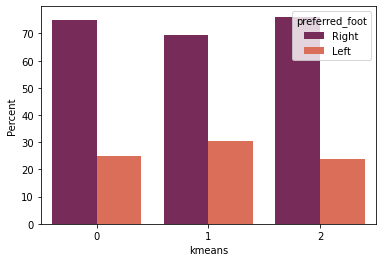

In [68]:
df_aux = df_clusters.groupby(['kmeans'])['preferred_foot'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
sns.barplot(x='kmeans', y='Percent', hue='preferred_foot', data=df_aux, palette='rocket')

Podemos observar que la mayoria de los jugadores son derechos. Y en el cluster 0 mas zurdos que en el claste 1 y 2 que tiene casi el mismo porcentaje.

**Silhouette Coefficient Method**

For n_clusters = 2 The average silhouette_score is : 0.28551410157808604
For n_clusters = 3 The average silhouette_score is : 0.25991990076231836
For n_clusters = 4 The average silhouette_score is : 0.22442466243907888
For n_clusters = 5 The average silhouette_score is : 0.18429631681042016
For n_clusters = 6 The average silhouette_score is : 0.16267797799324824
For n_clusters = 7 The average silhouette_score is : 0.15708401145944162
For n_clusters = 8 The average silhouette_score is : 0.13567057565757012
For n_clusters = 9 The average silhouette_score is : 0.12924387599729065
For n_clusters = 10 The average silhouette_score is : 0.12424300422962004
For n_clusters = 11 The average silhouette_score is : 0.1141704843606483


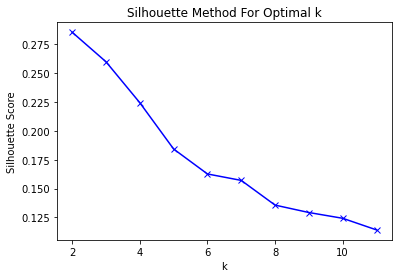

In [69]:
silhouette_scores = [] 
K = range(2, 12)

for k in K:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(df_skills)
    scr = silhouette_score(df_skills, km)
    silhouette_scores.append(scr)
    print("For n_clusters =", k, "The average silhouette_score is :", scr)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

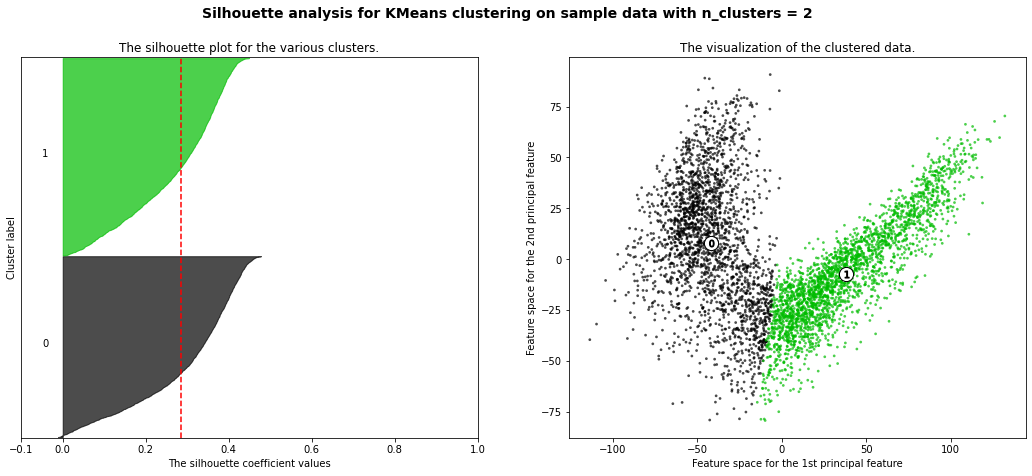

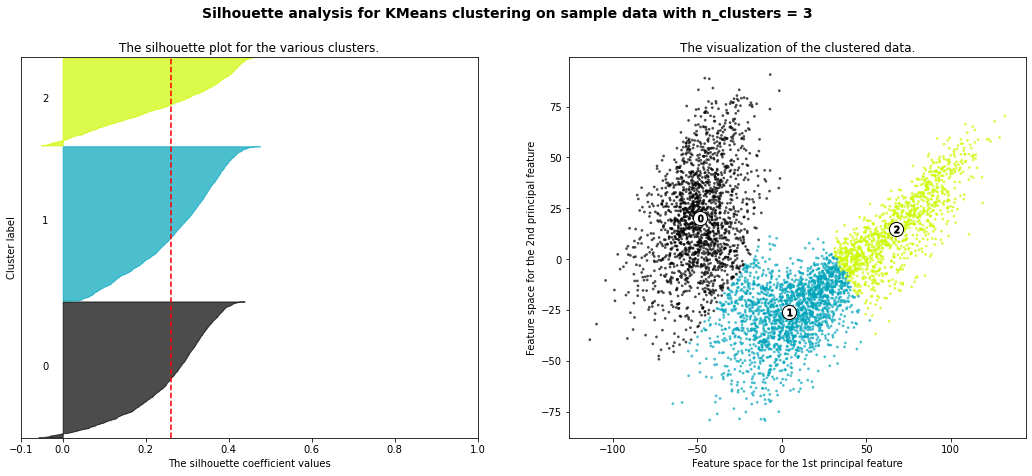

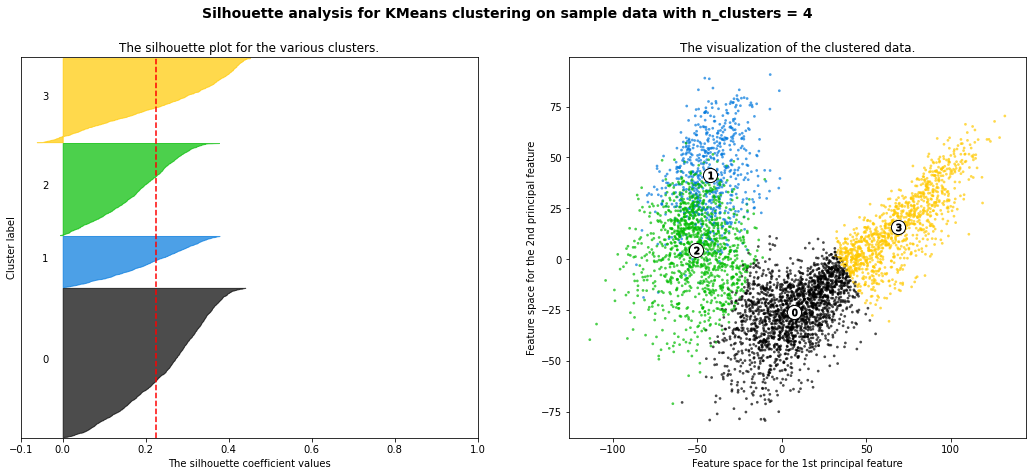

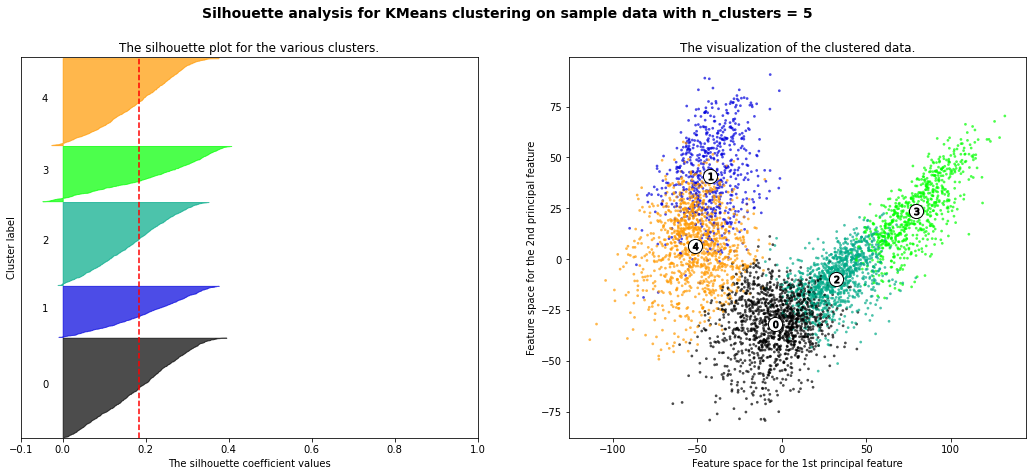

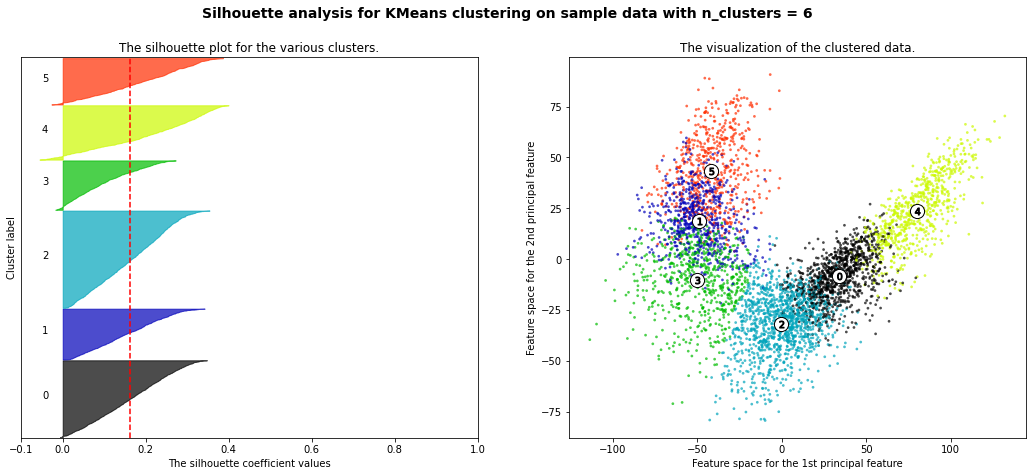

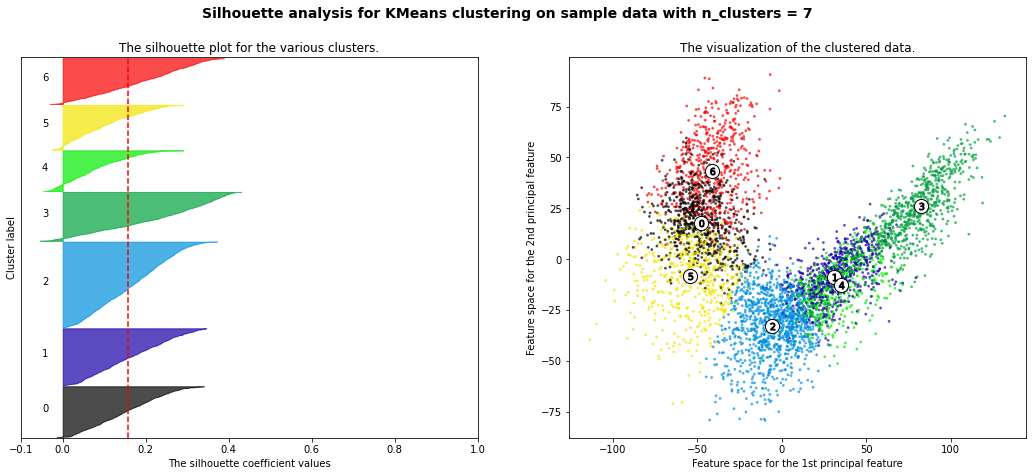

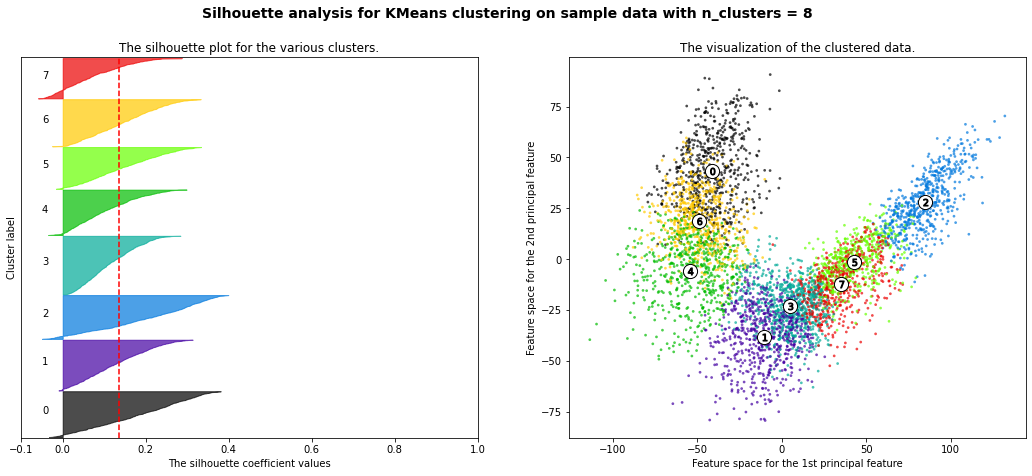

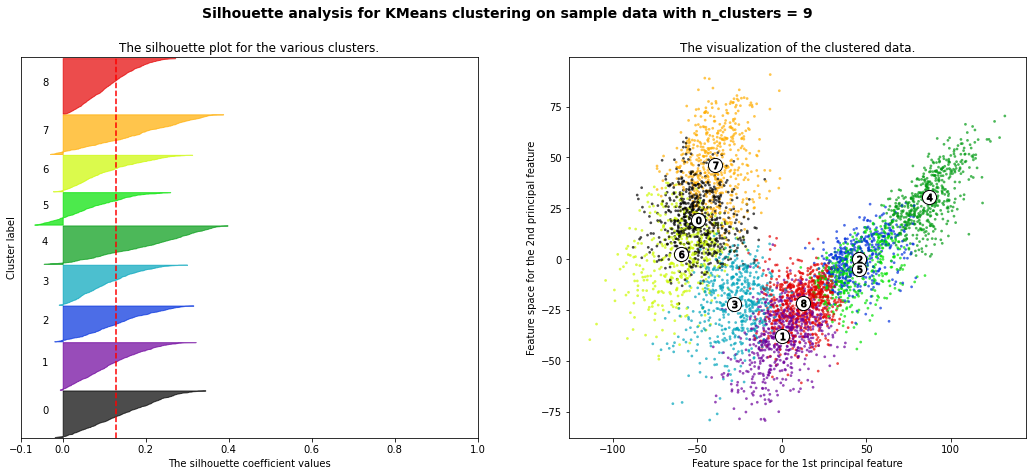

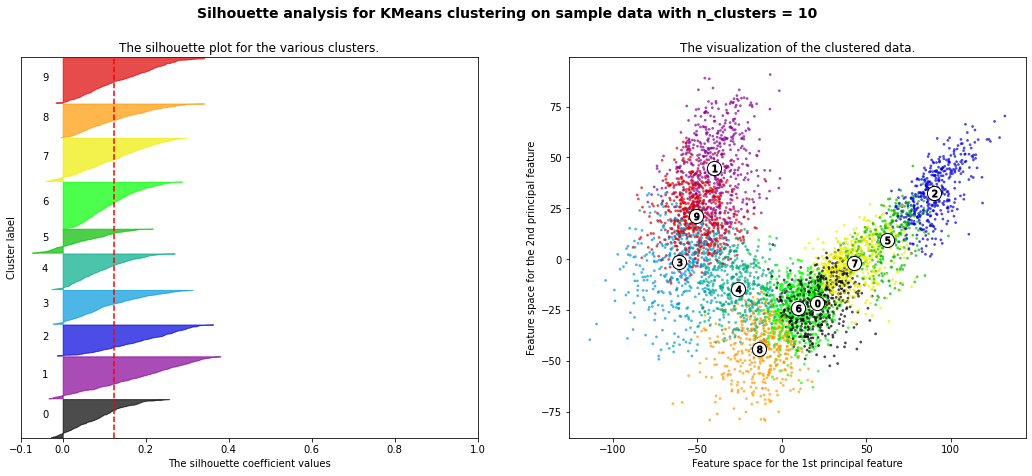

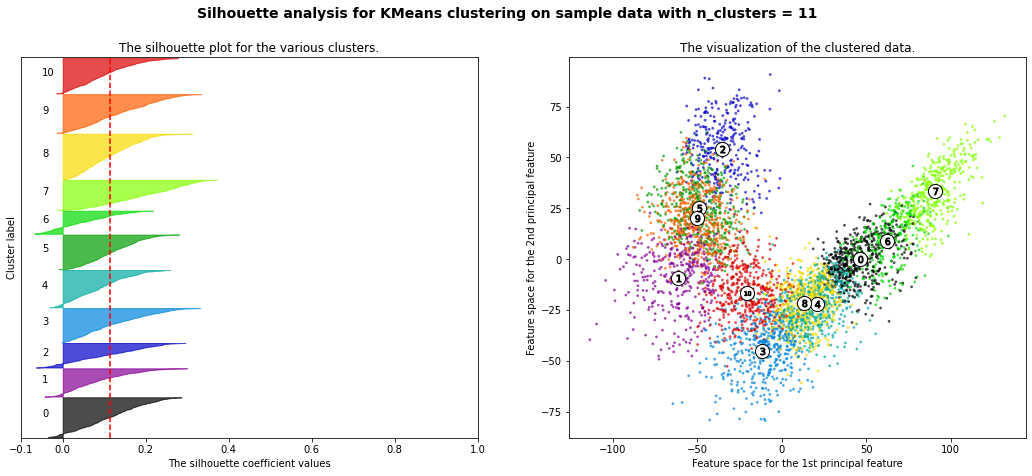

In [70]:
K = range(2,12)

for k in K:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df_skills) + (k + 1) * 10])

    clusterer = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = clusterer.fit_predict(df_skills)

    silhouette_avg = silhouette_score(df_skills, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_skills, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    pca = PCA(n_components=2)
    pca.fit(df_skills)
    X = pca.transform(df_skills)

    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    pca_centers = pca.transform(clusterer.cluster_centers_)
    # Draw white circles at cluster centers
    ax2.scatter(pca_centers[:, 0], pca_centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(pca_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st principal feature")
    ax2.set_ylabel("Feature space for the 2nd principal feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

plt.show()

In [71]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
dist = 1 - cosine_similarity(df_skills)

pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
X_PCA.shape

(4869, 2)

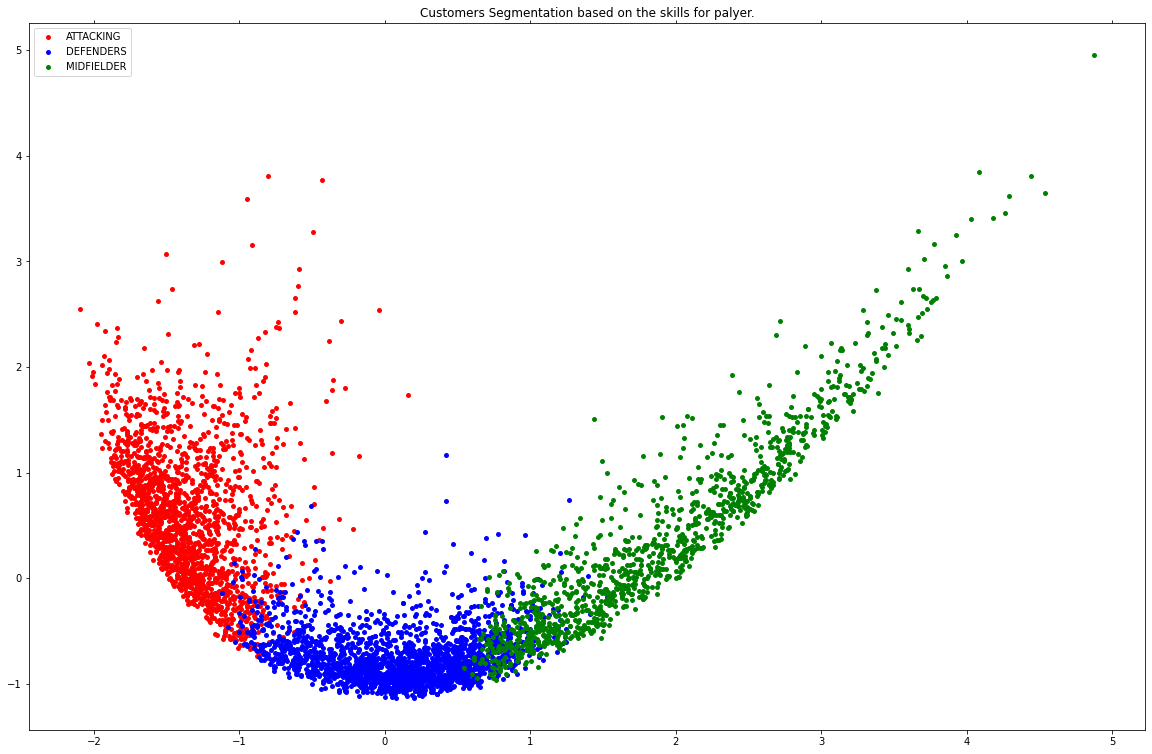

In [72]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green'
          }

names = {0: 'ATTACKING', 
         1: 'DEFENDERS', 
         2: 'MIDFIELDER'
         }
  
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("Customers Segmentation based on the skills for palyer.")
plt.show()

# 6.-Clustering-Mean-Shift-sin-arqueros 

In [73]:
ms = MeanShift(bandwidth=6, bin_seeding=True)## Con bandwidth en la mayoria de los caso da 1 cluster, con 5 da 2 clusters y con 6 da 3 clusters

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero de clusters encontrado por Mean Shift : %d" % n_clusters_)

Numero de clusters encontrado por Mean Shift : 3


In [74]:
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]
print(skill_1,skill_2)

attacking_finishing defending_sliding_tackle


In [75]:
MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [76]:
#En Jupyter
iplot(fig)

In [77]:
df_clusters['MeanShift'] = ms.labels_ #clusters2
print('Kmeans encontró: ', max(labels)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms.labels_)+1, 'clusters, según los hiperparámetros elegidos')

Kmeans encontró:  3 clusters, nosotros lo forzamos
Mean shift encontró  3 clusters, según los hiperparámetros elegidos


**Cantidad de observaciones por Cluster**

In [78]:
df_clusters.MeanShift.value_counts()

0    2093
1    1604
2    1172
Name: MeanShift, dtype: int64

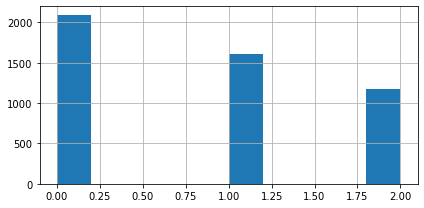

In [79]:
df_clusters.MeanShift.hist(figsize=(6, 3))
plt.tight_layout()

Se advierte que el Cluster con mayor cantidad de casos es el 0, contando con 2093 jugadores, seguido por el 1 con 1604 jugadores. Por último, el Cluster 0 agrupa 1172 jugadores.

**Análisis descriptivo separando por Cluster**

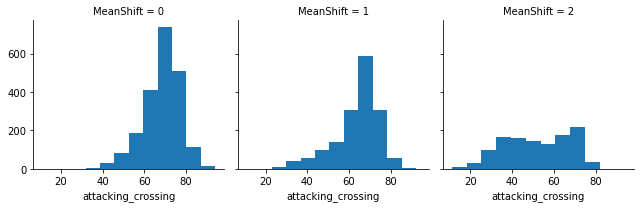

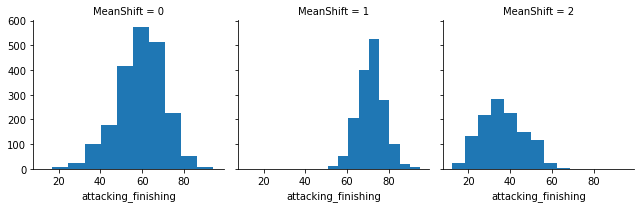

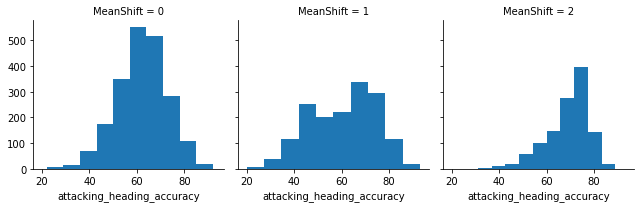

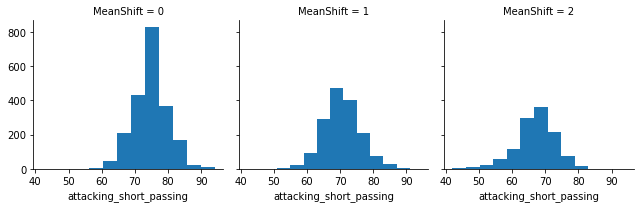

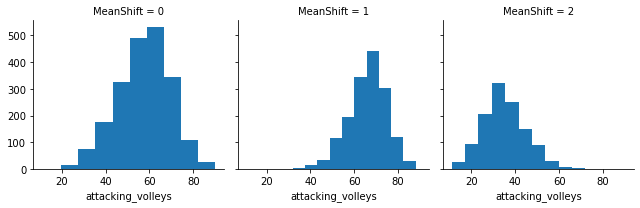

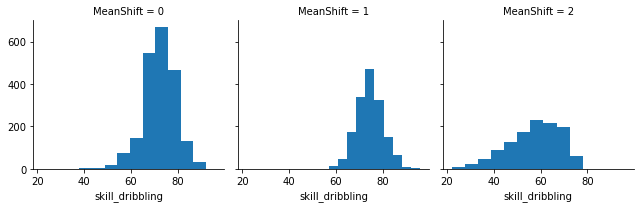

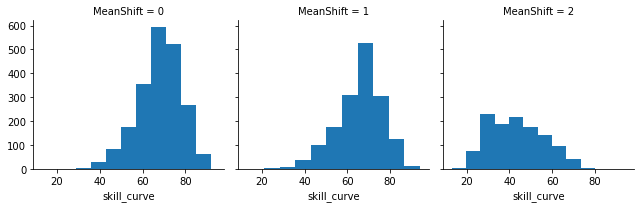

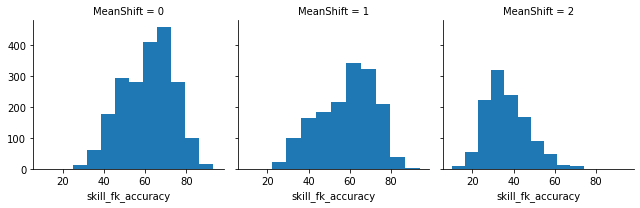

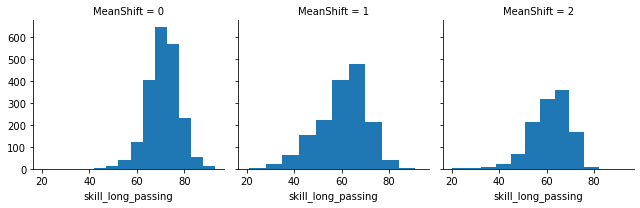

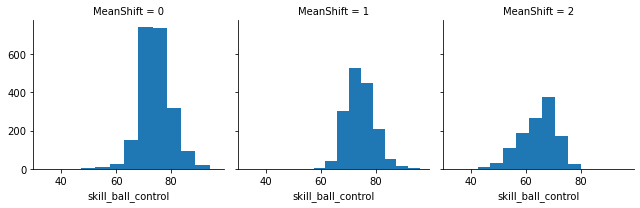

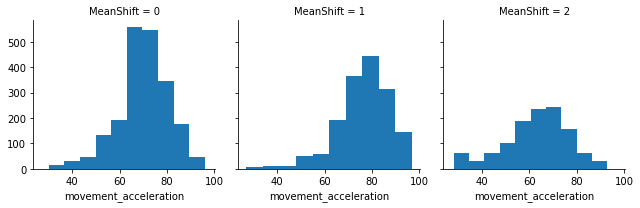

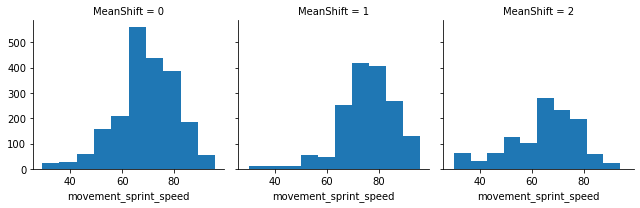

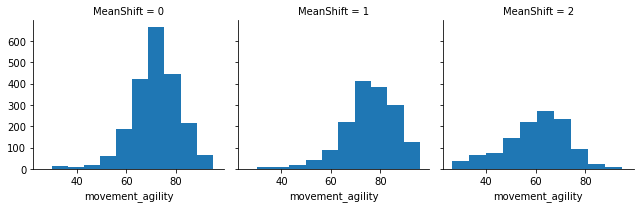

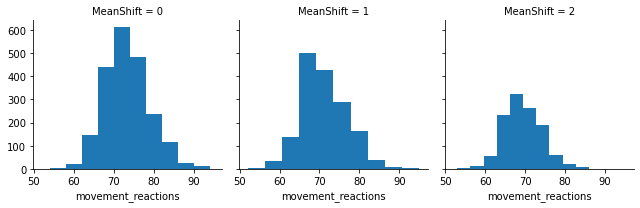

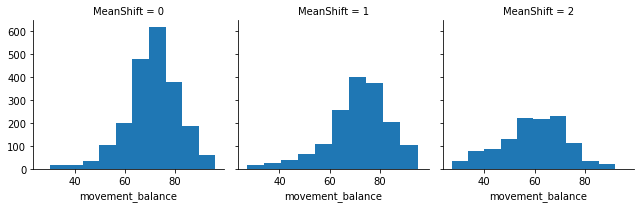

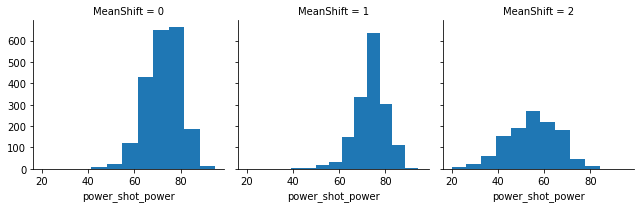

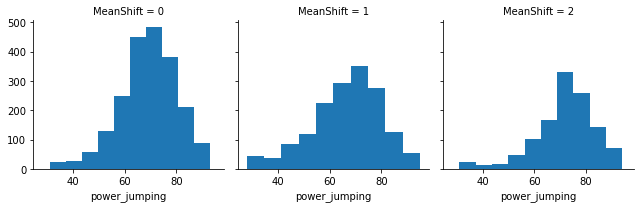

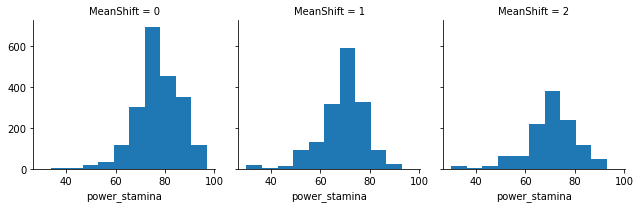

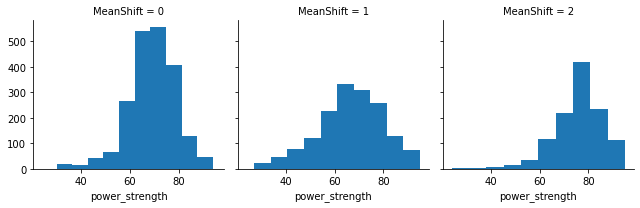

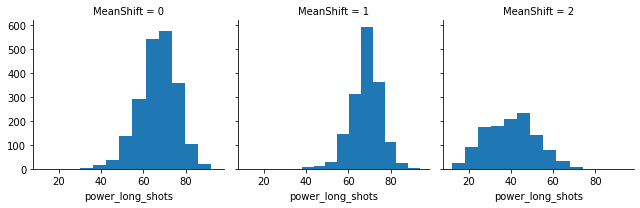

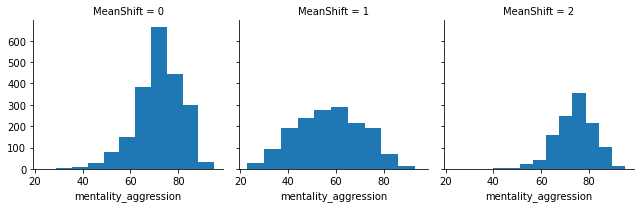

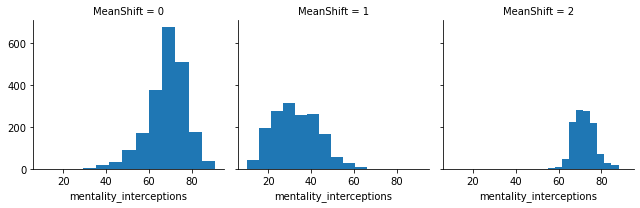

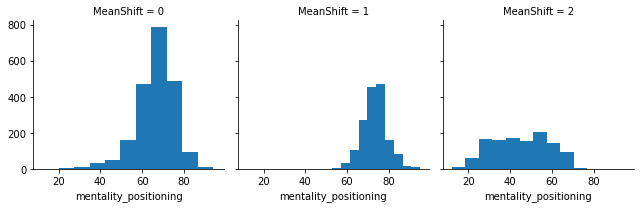

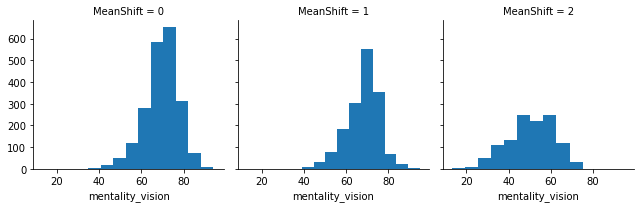

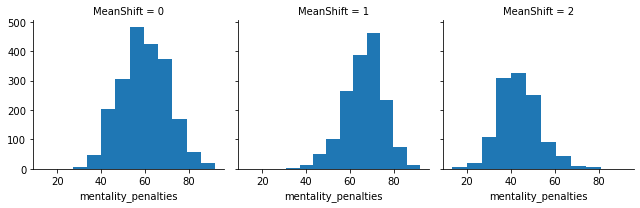

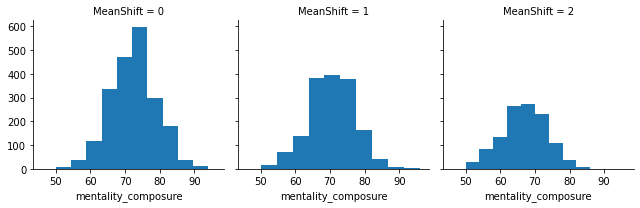

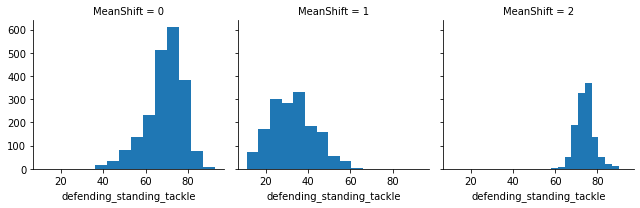

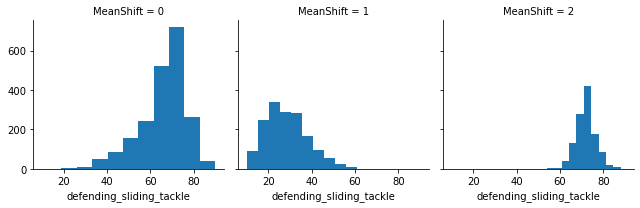

In [80]:
for c in df_clusters[skills_ratings]:
    grid = sns.FacetGrid(df_clusters, col='MeanShift')
    grid.map(plt.hist, c)

In [81]:
df_clusters_0=df_clusters[df_clusters["MeanShift"]==0]
df_clusters_0.describe()


sofifa_id          age    height_cm    weight_kg  league_rank  \
count    2093.000000  2093.000000  2093.000000  2093.000000  2057.000000   
mean   209069.176302    27.622551   179.502150    74.329193     1.106952   
std     24363.166434     3.898314     5.841732     6.217465     0.318428   
min        41.000000    17.000000   158.000000    55.000000     1.000000   
25%    193301.000000    25.000000   175.000000    70.000000     1.000000   
50%    210324.000000    28.000000   180.000000    74.000000     1.000000   
75%    228618.000000    30.000000   184.000000    78.000000     1.000000   
max    257889.000000    42.000000   197.000000   100.000000     3.000000   

           overall    potential     value_eur       wage_eur  \
count  2093.000000  2093.000000  2.093000e+03    2093.000000   
mean     74.825609    76.865743  7.725024e+06   29034.161491   
std       3.995776     4.762288  9.134107e+06   37140.622184   
min      70.000000    70.000000  0.000000e+00       0.000000   
25%      72.000000    73.000000  2.600000e+06    8000.000000   
50%      74.000000    76.000000  4.900000e+06   17000.000000   
75%      77.000000    80.000000  9.000000e+06   35000.000000   
max      91.000000    92.000000  8.700000e+07  370000.000000   

       international_reputation    weak_foot  skill_moves  release_clause_eur  \
count               2093.000000  2093.000000  2093.000000        1.981000e+03   
mean                   1.385093     3.190635     3.016245        1.507804e+07   
std                    0.675866     0.692398     0.606469        1.790418e+07   
min                    1.000000     1.000000     2.000000        2.900000e+05   
25%                    1.000000     3.000000     3.000000        4.800000e+06   
50%                    1.000000     3.000000     3.000000        9.400000e+06   
75%                    2.000000     4.000000     3.000000        1.780000e+07   
max                    5.000000     5.000000     5.000000        1.610000e+08   

       team_jersey_number  contract_valid_until  nation_jersey_number  \
count         2057.000000           2057.000000            375.000000   
mean            17.789499           2022.230919             11.944000   
std             14.847242              1.210226              6.384269   
min              2.000000           2020.000000              2.000000   
25%              8.000000           2021.000000              6.000000   
50%             15.000000           2022.000000             12.000000   
75%             23.000000           2023.000000             18.000000   
max             99.000000           2026.000000             26.000000   

              pace     shooting      passing    dribbling    defending  \
count  2093.000000  2093.000000  2093.000000  2093.000000  2093.000000   
mean     69.648829    63.664118    70.873387    72.662207    67.262781   
std      10.696913     8.121710     5.408523     5.915441     8.451455   
min      30.000000    39.000000    53.000000    45.000000    40.000000   
25%      64.000000    58.000000    67.000000    69.000000    63.000000   
50%      70.000000    64.000000    71.000000    73.000000    69.000000   
75%      77.000000    69.000000    74.000000    76.000000    73.000000   
max      96.000000    91.000000    93.000000    92.000000    91.000000   

            physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  gk_speed  \
count  2093.000000        0.0          0.0         0.0          0.0       0.0   
mean     71.629240        NaN          NaN         NaN          NaN       NaN   
std       6.859847        NaN          NaN         NaN          NaN       NaN   
min      45.000000        NaN          NaN         NaN          NaN       NaN   
25%      67.000000        NaN          NaN         NaN          NaN       NaN   
50%      72.000000        NaN          NaN         NaN          NaN       NaN   
75%      76.000000        NaN          NaN         NaN          NaN       NaN   
max      91.000000        NaN          NaN    

In [82]:
df_clusters_0=df_clusters[df_clusters["MeanShift"]==1]
df_clusters_0.describe()


sofifa_id          age    height_cm    weight_kg  league_rank  \
count    1604.000000  1604.000000  1604.000000  1604.000000  1569.000000   
mean   213345.503741    26.946384   179.216334    74.389027     1.123646   
std     27128.166120     4.096572     6.817464     7.224985     0.331213   
min      3467.000000    17.000000   157.000000    56.000000     1.000000   
25%    199823.250000    24.000000   175.000000    69.750000     1.000000   
50%    216539.000000    27.000000   179.000000    74.000000     1.000000   
75%    231433.750000    30.000000   184.000000    79.000000     1.000000   
max    258262.000000    40.000000   201.000000   104.000000     3.000000   

           overall    potential     value_eur       wage_eur  \
count  1604.000000  1604.000000  1.604000e+03    1604.000000   
mean     73.705736    76.141521  6.613186e+06   22602.556110   
std       3.556961     4.918352  8.149406e+06   31915.455607   
min      70.000000    70.000000  0.000000e+00       0.000000   
25%      71.000000    72.000000  2.475000e+06    7000.000000   
50%      73.000000    75.000000  4.000000e+06   14000.000000   
75%      75.000000    79.000000  8.000000e+06   27000.000000   
max      93.000000    95.000000  1.055000e+08  560000.000000   

       international_reputation    weak_foot  skill_moves  release_clause_eur  \
count               1604.000000  1604.000000  1604.000000        1.494000e+03   
mean                   1.296758     3.339152     3.291147        1.300399e+07   
std                    0.610136     0.701794     0.608237        1.627605e+07   
min                    1.000000     1.000000     2.000000        7.190000e+05   
25%                    1.000000     3.000000     3.000000        4.700000e+06   
50%                    1.000000     3.000000     3.000000        7.800000e+06   
75%                    1.000000     4.000000     4.000000        1.580000e+07   
max                    5.000000     5.000000     5.000000        2.031000e+08   

       team_jersey_number  contract_valid_until  nation_jersey_number  \
count         1569.000000           1569.000000            223.000000   
mean            19.124283           2022.267686             14.170404   
std             16.817575              1.282131              5.155040   
min              2.000000           2020.000000              3.000000   
25%              9.000000           2021.000000             10.000000   
50%             14.000000           2022.000000             14.000000   
75%             22.000000           2023.000000             19.000000   
max             99.000000           2028.000000             27.000000   

              pace     shooting      passing    dribbling    defending  \
count  1604.000000  1604.000000  1604.000000  1604.000000  1604.000000   
mean     75.754364    70.924564    66.049252    74.260599    35.955112   
std      10.340830     5.437553     7.012026     5.294276     7.188435   
min      30.000000    54.000000    44.000000    57.000000    18.000000   
25%      70.000000    68.000000    62.000000    71.000000    31.000000   
50%      77.000000    71.000000    67.000000    74.000000    36.000000   
75%      83.000000    74.000000    71.000000    77.000000    41.000000   
max      96.000000    93.000000    91.000000    95.000000    57.000000   

            physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  gk_speed  \
count  1604.000000        0.0          0.0         0.0          0.0       0.0   
mean     65.189526        NaN          NaN         NaN          NaN       NaN   
std       9.138171        NaN          NaN         NaN          NaN       NaN   
min      37.000000        NaN          NaN         NaN          NaN       NaN   
25%      59.000000        NaN          NaN         NaN          NaN       NaN   
50%      66.000000        NaN          NaN         NaN          NaN       NaN   
75%      72.000000        NaN          NaN         NaN          NaN       NaN   
max      90.000000        NaN          NaN    

In [83]:
df_clusters_0=df_clusters[df_clusters["MeanShift"]==2]
df_clusters_0.describe()


sofifa_id         age    height_cm    weight_kg  league_rank  \
count    1172.000000  1172.00000  1172.000000  1172.000000  1148.000000   
mean   215695.206485    26.90273   184.211604    78.358362     1.152439   
std     24180.253335     3.93097     6.190508     6.562677     0.362019   
min     18115.000000    18.00000   165.000000    57.000000     1.000000   
25%    201156.250000    24.00000   180.000000    74.000000     1.000000   
50%    219516.500000    27.00000   185.000000    78.000000     1.000000   
75%    232784.250000    30.00000   189.000000    83.000000     1.000000   
max    258370.000000    40.00000   199.000000   101.000000     3.000000   

           overall    potential     value_eur       wage_eur  \
count  1172.000000  1172.000000  1.172000e+03    1172.000000   
mean     72.991468    75.924061  4.697240e+06   18225.255973   
std       2.958857     4.414308  4.855470e+06   19886.538375   
min      70.000000    70.000000  0.000000e+00       0.000000   
25%      71.000000    72.000000  2.000000e+06    7000.000000   
50%      72.000000    75.000000  3.200000e+06   13000.000000   
75%      75.000000    79.000000  6.000000e+06   23000.000000   
max      88.000000    90.000000  5.000000e+07  220000.000000   

       international_reputation    weak_foot  skill_moves  release_clause_eur  \
count               1172.000000  1172.000000  1172.000000        1.105000e+03   
mean                   1.174061     2.833618     2.231229        9.283704e+06   
std                    0.456934     0.590673     0.427829        9.684311e+06   
min                    1.000000     1.000000     2.000000        3.600000e+05   
25%                    1.000000     2.000000     2.000000        3.900000e+06   
50%                    1.000000     3.000000     2.000000        6.100000e+06   
75%                    1.000000     3.000000     2.000000        1.150000e+07   
max                    4.000000     5.000000     4.000000        9.880000e+07   

       team_jersey_number  contract_valid_until  nation_jersey_number  \
count         1148.000000           1148.000000            143.000000   
mean            16.034843           2022.210801              9.405594   
std             14.916583              1.179964              6.683212   
min              2.000000           2020.000000              2.000000   
25%              4.000000           2021.000000              4.000000   
50%             14.000000           2022.000000              6.000000   
75%             24.000000           2023.000000             15.000000   
max             98.000000           2027.000000             23.000000   

              pace     shooting      passing    dribbling    defending  \
count  1172.000000  1172.000000  1172.000000  1172.000000  1172.000000   
mean     63.834471    41.581058    57.190273    60.376280    72.304608   
std      12.971423     8.172526     6.846903     8.313409     4.455516   
min      30.000000    16.000000    34.000000    34.000000    58.000000   
25%      56.000000    36.000000    53.000000    54.000000    69.000000   
50%      65.000000    42.000000    58.000000    61.000000    72.000000   
75%      73.000000    48.000000    62.000000    67.000000    75.000000   
max      94.000000    63.000000    73.000000    78.000000    90.000000   

            physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  gk_speed  \
count  1172.000000        0.0          0.0         0.0          0.0       0.0   
mean     73.803754        NaN          NaN         NaN          NaN       NaN   
std       5.795318        NaN          NaN         NaN          NaN       NaN   
min      46.000000        NaN          NaN         NaN          NaN       NaN   
25%      71.000000        NaN          NaN         NaN          NaN       NaN   
50%      74.000000        NaN          NaN         NaN          NaN       NaN   
75%      78.000000        NaN          NaN         NaN          NaN       NaN   
max      91.000000        NaN          NaN         NaN 

Como podemos observar, el cluster 2 se diferencia de los clusters 0 y 1 en relación a las variables altura, peso y salario. Los jugadores pertenecientes al cluster 2 poseen en promedio mayor altura y peso y, menores salarios que los jugadores pertenecientes a los clusters 0 y 1.

In [84]:
df_clusters.groupby(['MeanShift'])[skills_ratings].mean()

attacking_crossing  attacking_finishing  \
MeanShift                                            
0                   68.571906            59.125657   
1                   63.764963            71.708853   
2                   52.029010            36.439420   

           attacking_heading_accuracy  attacking_short_passing  \
MeanShift                                                        
0                           61.551362                74.621596   
1                           60.711347                69.998130   
2                           69.038396                67.007679   

           attacking_volleys  skill_dribbling  skill_curve  skill_fk_accuracy  \
MeanShift                                                                       
0                  57.374104        72.010989    67.500239          61.150502   
1                  65.904613        74.501870    65.800499          58.315461   
2                  35.247440        57.127986    43.480375          36.650171   

           skill_long_passing  skill_ball_control  movement_acceleration  \
MeanShift                                                                  
0                   70.915910           74.297659              69.993311   
1                   59.892768           74.334788              75.950125   
2                   61.534983           64.479522              62.721843   

           movement_sprint_speed  movement_agility  movement_reactions  \
MeanShift                                                                
0                      69.353082         71.722886           72.741997   
1                      75.598504         75.564838           71.031172   
2                      64.703925         59.947952           69.433447   

           movement_balance  power_shot_power  power_jumping  power_stamina  \
MeanShift                                                                     
0                 70.980411         72.489728      68.977066      77.203058   
1                 71.389651         73.539900      66.513716      69.137157   
2                 59.183447         54.853242      71.882253      70.509386   

           power_strength  power_long_shots  mentality_aggression  \
MeanShift                                                           
0               68.904921         66.760631             72.033923   
1               66.410848         68.270574             56.803616   
2               75.623720         40.041809             73.715870   

           mentality_interceptions  mentality_positioning  mentality_vision  \
MeanShift                                                                     
0                        68.585762              66.449594         69.738175   
1                        32.711347              73.155237         67.861596   
2                        72.025597              44.860922         50.286689   

           mentality_penalties  mentality_composure  \
MeanShift                                             
0                    59.542762            72.159102   
1                    66.377182            70.394638   
2                    43.650171            66.364334   

           defending_standing_tackle  defending_sliding_tackle  
MeanShift                                                       
0                          69.172002                 65.963688  
1                          32.492519                 28.708853  
2                          73.870307                 71.894198

In [85]:
for c in range(0,3):
    print(' Principales Skills:', c, ':')
    for skill, value in df_clusters[df_clusters.MeanShift == c].describe()[skills_ratings].loc['mean',:].sort_values(ascending=False)[:5].items():
        print('       ',skill,':', '%.2f' % value)

 Principales Skills: 0 :
        power_stamina : 77.20
        attacking_short_passing : 74.62
        skill_ball_control : 74.30
        movement_reactions : 72.74
        power_shot_power : 72.49
 Principales Skills: 1 :
        movement_acceleration : 75.95
        movement_sprint_speed : 75.60
        movement_agility : 75.56
        skill_dribbling : 74.50
        skill_ball_control : 74.33
 Principales Skills: 2 :
        power_strength : 75.62
        defending_standing_tackle : 73.87
        mentality_aggression : 73.72
        mentality_interceptions : 72.03
        defending_sliding_tackle : 71.89


Cluster 0: Agrupa a los jugadores de medio campo 

Cluster 1: Agrupa a los jugadores delanteros y algunos medio campo

Cluster 2: Agrupa a los defensores.

**Tabla de contingencia alguna categórica vs clusters**

In [86]:
df_clusters.groupby(['preferred_foot','MeanShift'])['MeanShift'].count()

preferred_foot  MeanShift
Left            0             637
                1             389
                2             284
Right           0            1456
                1            1215
                2             888
Name: MeanShift, dtype: int64

<AxesSubplot:xlabel='MeanShift', ylabel='Percent'>

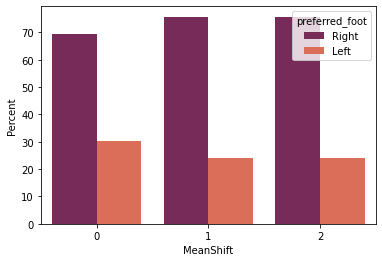

In [87]:
df_aux = df_clusters.groupby(['MeanShift'])['preferred_foot'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
sns.barplot(x='MeanShift', y='Percent', hue='preferred_foot', data=df_aux, palette='rocket')

Podemos observar que la mayoria de los jugadores son derechos. Y en el cluster 0 mas zurdos que en el claste 1 y 2 que tiene casi el mismo porcentaje.

**Silhouette Coefficient Method**

In [88]:
ms = MeanShift(bandwidth=6, bin_seeding=True)
ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(df_skills, clusters2))

Cantidad de clusters encontrados por Mean Shift : 3
Silhouette Coefficient: 0.245


In [89]:
ms = MeanShift(bandwidth=6, bin_seeding=True)
ms.fit(df_skills)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

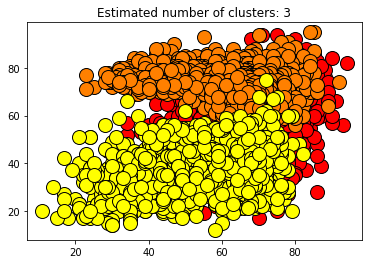

In [90]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.autumn(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    cluster_center = cluster_centers[k]

    xy = df_skills[class_member_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
    
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()